In [1]:
import numpy as np

filename = "./resampled_data_Bio_correlation_2.npz"
npzfile = np.load(filename)
print(npzfile.files)

target_data = npzfile['arr_0']
non_target_data = npzfile['arr_1']

print("Target data shape: ", target_data.shape)
print("Non-target data shape: ", non_target_data.shape)

file2 = "./resampled_data_test.npz"
npzfile2 = np.load(file2)
print(npzfile2.files)

test_data = npzfile2['arr_0']
non_test_data = npzfile2['arr_1']

print("Target data shape: ", test_data.shape)
print("Non-target data shape: ", non_test_data.shape)


['arr_0', 'arr_1']
Target data shape:  (9030, 7, 180)
Non-target data shape:  (9030, 7, 180)
['arr_0', 'arr_1']
Target data shape:  (210, 7, 180)
Non-target data shape:  (210, 7, 180)


In [3]:

from sklearn.model_selection import train_test_split

X = np.concatenate([target_data, non_target_data])
y = np.concatenate([np.ones(target_data.shape[0]), np.zeros(non_target_data.shape[0])])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=777)
print("X_train shape: ", X_train.shape)
print("Y_train shape: ", y_train.shape)
print(X_train)
print(y_train)
print("\nX_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)
print(y_test)

X_train shape:  (13545, 7, 180)
Y_train shape:  (13545,)
[[[-4.20856316e-01 -4.58121438e-01 -4.31665334e-01 ...  1.41038306e+00
    1.23563611e+00  9.96990561e-01]
  [-7.64036351e-02 -3.08013794e-02  2.96387972e-02 ...  1.08679154e-01
    1.17298031e-01  1.20551505e-01]
  [-7.95234988e-01 -8.31482463e-01 -8.27844010e-01 ... -1.44607028e-01
   -8.86794509e-02 -2.93303774e-02]
  ...
  [-1.85114996e-01 -2.25725438e-01 -1.89812716e-01 ... -2.92115778e-01
   -2.13881137e-01 -1.34583218e-01]
  [-3.43373143e-02  1.61189585e-02  1.34655334e-01 ... -4.17940707e-01
   -3.53806522e-01 -2.63114657e-01]
  [ 2.86959739e-01  1.69879561e-01  6.34441480e-02 ... -3.32827273e-01
   -3.42073648e-01 -3.28320374e-01]]

 [[ 4.14132439e-01  3.03714434e-01  1.41774072e-01 ... -3.56910456e-01
   -3.68263938e-01 -3.55176261e-01]
  [ 1.77344208e-02  5.40329593e-02  9.92530588e-02 ...  1.62277041e-01
    1.26511115e-01  9.65977198e-02]
  [-1.96952704e+00 -1.92519266e+00 -1.85221867e+00 ...  3.04423291e-01
    4.31

In [30]:
import warnings
import torch
import random
warnings.filterwarnings("ignore")

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(777)

In [31]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        conv1 = nn.Conv1d(7, 3, 3, 1, padding=True) 
        max_pool = nn.MaxPool1d(4)
        self.bn1 = nn.BatchNorm1d(3)
        fc1 = nn.Linear(3*1*45, 2) # fully connected layer 1번 
        
        self.conv = nn.Sequential(
            conv1,  # N x 7 x 180 -> N x 3 x 180
            self.bn1,
            nn.ReLU(),
            max_pool  # N x 3 x 180 -> N x 3 x 45
        )
        
        self.fc = nn.Sequential(
            fc1,  # N x 1024 -> N x 32
            nn.Softmax()  # 이건 분류 할때 사용 한거  out 이 1개일땐 다른거 쓰면 
        )

    def forward(self, x):
        x = self.conv(x)
        dim = 1
        for d in x.size()[1:]: #  N x 16 x 1 x 128
            dim = dim * d
            
        x = x.view(-1, dim)
        x = self.fc(x)
        return x

In [32]:
from EEGDataset import EEGDataset
from torch.utils.data import DataLoader
import torch

batch_size = 4

train_loader = DataLoader(
                EEGDataset(X_train, y_train), 
                batch_size=batch_size, 
                shuffle=True)

test_loader = DataLoader(
                EEGDataset(X_test, y_test),
                batch_size=batch_size,
                shuffle=False)

In [33]:
import torch
import torch.nn as nn
from torch import optim

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CNN().to(DEVICE)

criterion = nn.BCELoss()
lr = 1e-4
# 더 천천히 모델은 분석 하는것 
optimizer = optim.Adam(model.parameters(), lr=lr) # Adam optimizer -->내려가는 방법 생각해보기 == lr learning mate 적절하게 하면 좋다. adam 은 0.001 줄여보면서 
epochs = 15

In [34]:
from sklearn.metrics import accuracy_score

train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []

num_batches = len(train_loader)
for epoch in range(epochs):
    train_loss = 0
    train_acc = 0
    for i, data in enumerate(train_loader):
        """ 
        이번 학습에 사용될 데이터를 Batch 단위로 불러옵니다.
        우리는 이전에 batch_size를 4로 설정했으므로, 4개의 데이터가 불러와집니다.
        """

        data, label = data['data'].float().to(DEVICE), data['labels'].float().to(DEVICE)
        """
        optimizer.zero_grad(): 함수를 사용하여 기존에 남아있던 gradient를 모두 제거해줍니다.
        이는 이전 데이터가 새로 학습될 데이터에 영향을 끼치는 것을 막아줍니다.
        
        output = model(data): CNN 모델에 학습 데이터를 넣고 결과를 만들어냅니다.
        
        loss = criterion(output, label): 모델이 만들어낸 결과와, 실제 정답간의 차이를 이용해서 오차 값을 만들어 냅니다.
        추후에 이 값을 이용하여 모델이 학습을 하게 됩니다.
        
        loss.backward(): 위에서 만들어낸 오차 값을 각 노드에게 전파하여 각 노드가 업데이트 해야 할 오차가 얼마인지 찾아냅니다.
        
        optimizer.stop(): 각 노드별로 받은 오차를 가지고 optimizer의 방법 (여기서는 Adam)을 기반으로 weight를 업데이트 합니다.
        """
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        
        # Visualization을 위해 loss값과 accuracy를 저장합니다.
        train_loss += loss.item()
        train_acc += accuracy_score(np.argmax(label.cpu().detach().numpy(), axis=1), np.argmax(output.cpu().detach().numpy(), axis=1))
        
        """
        10번의 batch마다 test를 진행합니다.
        모델을 test할 때는 weight를 업데이트 시키면 안되기 때문에 torch.no_grad()를 이용합니다.
        """
        if (i + 1) % 1000 == 0:
            test_loss = 0
            test_acc = 0
            with torch.no_grad():
                for j, test_data in enumerate(test_loader):
                    test_data, test_label = test_data['data'].float().to(DEVICE), test_data['labels'].float().to(DEVICE)
                    test_output = model(test_data)
                    loss = criterion(test_output, test_label)
                    
                    test_loss += loss.item()
                    test_acc += accuracy_score(np.argmax(test_label.cpu().detach().numpy(), axis=1), np.argmax(test_output.cpu().detach().numpy(), axis=1))
            
            print('epoch: {}/{} | step: {}/{} | train_loss: {:.4f} | test_loss: {:.4f} | acc: {:.4f}'.format(
                epoch + 1, epochs, i + 1, num_batches, train_loss / 1000, test_loss / len(test_loader), test_acc / len(test_loader)
            ))
            
            train_loss_list.append(train_loss / 1000)
            train_acc_list.append(train_acc / 1000)
            test_loss_list.append(test_loss / len(test_loader))
            test_acc_list.append(test_acc / len(test_loader))
            train_loss = 0
            train_acc = 0

epoch: 1/15 | step: 1000/3387 | train_loss: 0.7228 | test_loss: 0.7045 | acc: 0.5143
epoch: 1/15 | step: 2000/3387 | train_loss: 0.6989 | test_loss: 0.6892 | acc: 0.5444
epoch: 1/15 | step: 3000/3387 | train_loss: 0.6786 | test_loss: 0.6737 | acc: 0.5834
epoch: 2/15 | step: 1000/3387 | train_loss: 0.6563 | test_loss: 0.6556 | acc: 0.6058
epoch: 2/15 | step: 2000/3387 | train_loss: 0.6491 | test_loss: 0.6473 | acc: 0.6233
epoch: 2/15 | step: 3000/3387 | train_loss: 0.6448 | test_loss: 0.6416 | acc: 0.6332
epoch: 3/15 | step: 1000/3387 | train_loss: 0.6311 | test_loss: 0.6365 | acc: 0.6405
epoch: 3/15 | step: 2000/3387 | train_loss: 0.6300 | test_loss: 0.6335 | acc: 0.6374
epoch: 3/15 | step: 3000/3387 | train_loss: 0.6292 | test_loss: 0.6305 | acc: 0.6470
epoch: 4/15 | step: 1000/3387 | train_loss: 0.6173 | test_loss: 0.6269 | acc: 0.6495
epoch: 4/15 | step: 2000/3387 | train_loss: 0.6229 | test_loss: 0.6267 | acc: 0.6529
epoch: 4/15 | step: 3000/3387 | train_loss: 0.6248 | test_loss: 0

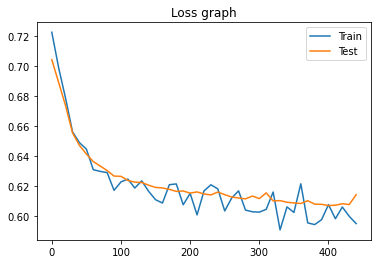

In [38]:
import matplotlib.pyplot as plt

x_tick = np.arange(0, len(train_loss_list) * 10, 10)
plt.title('Loss graph')
plt.plot(x_tick, train_loss_list, label='Train')
plt.plot(x_tick, test_loss_list, label='Test')
plt.legend()

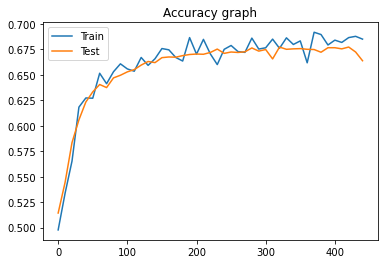

In [39]:
x_tick = np.arange(0, len(train_acc_list) * 10, 10)
plt.title('Accuracy graph')
plt.plot(x_tick, train_acc_list, label='Train')
plt.plot(x_tick, test_acc_list, label='Test')
plt.legend()

In [40]:

model_save='D:/P300_biosemi_55/Model/Bio/ZERO_Bio.pt'
model_save_weights='D:/P300_biosemi_55/Model/Bio/Weight/ZERO_Weight_Bio.pt'
torch.save(model, model_save)
torch.save(model.state_dict(), model_save_weights)
model.eval()

CNN(
  (bn1): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv): Sequential(
    (0): Conv1d(7, 3, kernel_size=(3,), stride=(1,), padding=(True,))
    (1): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=135, out_features=2, bias=True)
    (1): Softmax(dim=None)
  )
)

ans_label [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0]
1 score: 0.6756756756756757
ans_label [0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1]
2 score: 0.4666666666666667
ans_label [0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0]
3 score: 0.4358974358974359
ans_label [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0]
4 score: 0.7
ans_label [0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0]
5 score: 0.4
ans_label [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0]
6 score: 0.6666666666666666
ans_label [0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
7 score: 0.3
ans_label [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
8 score: 0.9333333333333333
ans_label [0,

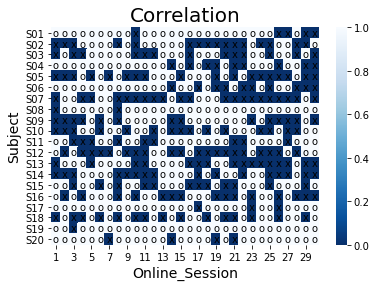

In [41]:
import numpy as np
from scipy.signal import butter, lfilter, sosfiltfilt
import time
import os, glob
import hdf5storage
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import joblib
import shutil
from datetime import datetime
import socket
from scipy import signal
import matplotlib.pyplot as plt
from keras.models import load_model
import pandas as pd
from pandas import DataFrame  # 데이터프레임 클래스

import seaborn as sns

Classifier_path = 'D:\\P300_biosemi_55\\Model\\Bio\\'
classifier_list = sorted(glob.glob(Classifier_path + '*.pt'), key=os.path.getmtime, reverse=True)
weight_list = sorted(glob.glob(Classifier_path + 'Weight\\*.pt'), key=os.path.getmtime, reverse=True)
model = torch.load(classifier_list[0])
model.load_state_dict(torch.load(weight_list[0]))

# filtering bandwidth
low, high = 0.23, 30

resampleRate = 100    
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y

def Standardization(Epochs):
    for i in range(Epochs.shape[1]):
        Epochs[:,i,:] = np.subtract(Epochs[:,i,:], np.mean(Epochs[:,i,:]))
        Epochs[:,i,:] = Epochs[:,i,:] / np.std(Epochs[:,i,:])
    
    return Epochs    
def baseline_correction(Epochs):
    for i in range(Epochs.shape[1]):
        for j in range(Epochs.shape[0]):
            Epochs[j,i,:] = np.subtract(Epochs[j,i,:], np.mean(Epochs[j,i,:]))
    
    return Epochs       
def Epoching(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
            for i in range(nChannel):
                Epochs[j,i,:] = Epochs[j,i,:] - np.mean(Epochs[j,i,:])
                
        #Epochs = baseline_correction(Epochs)
        Epochs_Aver = np.mean(Epochs, axis=0)

        return Epochs_Aver
    
def Convert_to_FeatureVector(Epochs, buttonNum, featureNum):
    Features = np.zeros((buttonNum, featureNum))
    for i in range(buttonNum):
        Features[i, :] = np.reshape(Epochs[i, :, :], (1, featureNum))
    return Features

def resampling(Epochs, resampleRate, channelNum):
        resampled_epoch = np.zeros((channelNum, resampleRate))
        for j in range(channelNum):
            resampled_epoch[j,:] = signal.resample(Epochs[j,:], resampleRate)
            
        return resampled_epoch
    
def main():
    sum=0
    Total_Score=0.0
    total_label =[]
    for k in np.arange(1,21):
        root="D:\\VR300_20\\S"
        if(k<10):
            filename = root + '0' + str(k)
        else:
            filename = root + str(k)
        #root_path = "D:\\VR300_20\\S03\\"

        mat_path = filename + '\\Online\\mat\\'
        current_list = sorted(glob.glob(mat_path + '*.mat'), key=os.path.getmtime)
        score = 0
        ans_label= []
        wrong_ans = []
        
        target_val = nontarget_val = 0
        for mat_file in current_list:
            #print(mat_file)
            ans = mat_file[-5]
            
            mat = hdf5storage.loadmat(mat_file)
            channelNames = mat['channelNames']
            eegData = mat['eegData']
            samplingFreq = mat['samplingFreq']
            samplingFreq = samplingFreq[0,0]
            stims = mat['stims']
            channelNum = channelNames.shape
            channelNum = channelNum[1]
            eegData = np.transpose(eegData)
            buttonNum = 7
            
            #Bandpass Filter
            eegData = butter_bandpass_filter(eegData, low, high, samplingFreq, order=4)

            #Epoching
            epochSampleNum = int(np.floor(0.6 * samplingFreq))
            offset = int(np.floor(0.2 * samplingFreq))
            baseline = int(np.floor(0.8 * samplingFreq))
            
            ####### averaging whole epochs
            Epochs_Aver = np.zeros((buttonNum, channelNum, epochSampleNum))
            Epochs_final = np.zeros((buttonNum, channelNum, resampleRate))
            
            featureNum = channelNum*resampleRate
            
            for i in range(buttonNum):
                Epochs_Aver[i] = Epoching(eegData, stims, (i+1), samplingFreq, channelNum, epochSampleNum, offset, baseline)
                Epochs_final[i] = resampling(Epochs_Aver[i], resampleRate, channelNum)
            #answer=model(Epochs_final)
            
            #print(Epochs_Aver.shape)
            b=torch.Tensor(Epochs_Aver[:,:,:].reshape(7,7,180)).to(DEVICE)
            test_output=model(b)
            test_output[:, 1].max(dim=0)
            #print(test_output)
            predict= test_output[:, 1].max(dim=0)[1]+1
            
            if int(ans) == int(predict): 
                #ans_label.append(mat_file[mat_file.rfind('\\')+1:mat_file.rfind('_')])
                if(len(ans_label)>29):
                    continue
                ans_label.append(1)
                score = score + 1
            else:
                wrong_ans.append(mat_file[mat_file.rfind('\\')+1:mat_file.rfind('_')])
                if(len(ans_label)>29):
                    continue
                ans_label.append(0)
            #print('order: ', ans, 'predict: ', predict)
        
        print('ans_label', ans_label)
        total_label.append(ans_label)
        print(k,'score:', score/(len(wrong_ans)+score))
        
        if k % 2 == 0:           
            sum=sum+ score/(len(wrong_ans)+score)
    print(sum/10)
    print(total_label)
    df = pd.DataFrame(total_label,
                   index=['S01','S02','S03','S04','S05','S06','S07','S08','S09','S10','S11','S12','S13','S14','S15','S16','S17','S18','S19','S20'],
                   columns=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30])
    print(df)
# heatmap by plt.pcolor()

    for i in range(df.shape[1]):
        for j in range(df.shape[0]):
            if round(df.iloc[j,i],2) == 1:
                plt.text(i+0.5,j+0.5,'o',ha='center',va='center')
            else:
                plt.text(i+0.5,j+0.5,'x',ha='center',va='center')

    sns.heatmap(df, cmap='Blues_r')
    plt.title('Correlation', fontsize=20)
    plt.xlabel('Online_Session', fontsize=14)
    plt.ylabel('Subject', fontsize=14)
    plt.show()



if __name__ == "__main__":
    main()

D:\P300_biosemi_55\Model\Bio\ZERO_Bio.pt
3


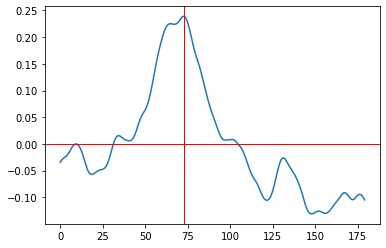

73
tensor([[3.7146e-01, 6.2854e-01],
        [1.1003e-01, 8.8997e-01],
        [9.8009e-01, 1.9906e-02],
        [7.4933e-01, 2.5067e-01],
        [4.6118e-02, 9.5388e-01],
        [8.2680e-06, 9.9999e-01],
        [6.4144e-01, 3.5856e-01]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  3 predict:  tensor(6, device='cuda:0')
tensor([[3.6838e-01, 6.3162e-01],
        [2.4118e-04, 9.9976e-01],
        [9.9512e-01, 4.8791e-03],
        [3.0557e-03, 9.9694e-01],
        [5.2343e-02, 9.4766e-01],
        [7.0705e-03, 9.9293e-01],
        [9.3595e-01, 6.4053e-02]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  1 predict:  tensor(2, device='cuda:0')
tensor([[5.3292e-08, 1.0000e+00],
        [8.2088e-01, 1.7912e-01],
        [1.7565e-01, 8.2435e-01],
        [9.6927e-02, 9.0307e-01],
        [2.8279e-06, 1.0000e+00],
        [9.2202e-03, 9.9078e-01],
        [2.0872e-01, 7.9128e-01]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  2 predict:  tensor(1, device='cuda:0')
tensor(

In [42]:
import numpy as np
from scipy.signal import butter, lfilter, sosfiltfilt
import time
import os, glob
import hdf5storage
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import joblib
import shutil
from datetime import datetime
import socket
from scipy import signal
import matplotlib.pyplot as plt
from keras.models import load_model
import torch
import torch.nn as nn
from torch import optim
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CNN().to(DEVICE)

criterion = nn.BCELoss()
lr = 1e-5
# 더 천천히 모델은 분석 하는것 
optimizer = optim.Adam(model.parameters(), lr=lr)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        conv1 = nn.Conv1d(7, 3, 3, 1, padding=True) # 1, 6 은 임의로 한것
        max_pool = nn.MaxPool1d(4)
        self.bn1 = nn.BatchNorm1d(3)
        fc1 = nn.Linear(3*1*45, 2) # fully connected layer 1번 
        
        self.conv = nn.Sequential(
            conv1,  # N x 7 x 180 -> N x 3 x 180
            self.bn1,
            nn.ReLU(),
            max_pool,  # N x 3 x 180 -> N x 3 x 45

        )
        
        self.fc = nn.Sequential(
            fc1,  # N x 1024 -> N x 32
            nn.Softmax()  # 이건 분류 할때 사용 한거  out 이 1개일땐 다른거 쓰면 
        )

    def forward(self, x):
        x = self.conv(x)
        dim = 1
        for d in x.size()[1:]: #  N x 16 x 1 x 128
            dim = dim * d
            
        x = x.view(-1, dim)
        x = self.fc(x)
        return x
            
Classifier_path = 'D:\\P300_biosemi_55\\Model\\Bio\\'
classifier_list = sorted(glob.glob(Classifier_path + '*.pt'), key=os.path.getmtime, reverse=True)
weight_list = sorted(glob.glob(Classifier_path + 'Weight\\*.pt'), key=os.path.getmtime, reverse=True)
print(classifier_list[0])
model = torch.load(classifier_list[0])
model.load_state_dict(torch.load(weight_list[0]))

# filtering bandwidth
low, high = 0.23, 30

    
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y

def Standardization(Epochs):
    for i in range(Epochs.shape[1]):
        Epochs[:,i,:] = np.subtract(Epochs[:,i,:], np.mean(Epochs[:,i,:]))
        Epochs[:,i,:] = Epochs[:,i,:] / np.std(Epochs[:,i,:])
    
    return Epochs    
    
def Epoching(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
            for i in range(nChannel):
                Epochs[j,i,:] = Epochs[j,i,:] - np.mean(Epochs[j,i,:])
                
#         Epochs = Standardization(Epochs)
        Epochs_Aver = np.mean(Epochs, axis=0)

        return Epochs_Aver
def Balancing_DataSet(Epochs, size):
        Epochs_New = np.zeros((size, Epochs.shape[1], Epochs.shape[2]))
    
        index = np.random.choice(Epochs.shape[0], size = size, replace = False)
    
        Epochs_New = Epochs[index, :, :]
    
        return Epochs_New
def Epoching_v(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
        return [Epochs, Num[0]]    
def plotGraph_v(filename):


        mat = hdf5storage.loadmat(filename)
        channelNames = mat['channelNames']
        eegData = mat['eegData']
        samplingFreq = mat['samplingFreq']
        samplingFreq = samplingFreq[0,0]
        stims = mat['stims']
        channelNum = channelNames.shape
        channelNum = channelNum[1]
        eegData = np.transpose(eegData)
        
        
        #Bandpass Filter
        eegData = butter_bandpass_filter(eegData, 0.23, 30, samplingFreq, order=4)
    
        #Epoching
        epochSampleNum = int(np.floor(0.6 * samplingFreq))
        offset = int(np.floor(0.2 * samplingFreq)) 
        baseline = int(np.floor(0.8 * samplingFreq)) 
        [EpochsT, NumT] = Epoching_v(eegData, stims, 1, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        [EpochsN, NumN] = Epoching_v(eegData, stims, 0, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        
        EpochsN_New = Balancing_DataSet(EpochsN, NumT)
        
        EpochsT = Standardization(EpochsT)
        EpochsN = Standardization(EpochsN_New)
        Target_All=np.mean(EpochsT,axis=0)
        
        return [EpochsT[:,:,:], EpochsN[:,:,:]]  

    
def main():
     #--------------------------------------------------------------    
        root = 'D:\\VR300_20\\S'
        T_all_V= np.zeros((8*210,7,180))
        N_all_V= np.zeros((8*210,7,180))
        count = 0

        for i in np.arange(1,20):
            if i % 2 == 1: 
                if (i==7 or i==13):
                    continue
                if(i<10):
                    count = count + 1
                    root_VR = root + '0' + str(i)+'/Training/mat/'
                    current_list = sorted(glob.glob(root_VR + '*.mat'), key=os.path.getmtime, reverse=True)
                    root_VR = current_list[0]
                else:
                    count = count + 1
                    root_VR = root + str(i)+'/Training/mat/'
                    current_list = sorted(glob.glob(root_VR + '*.mat'), key=os.path.getmtime, reverse=True)
                    root_VR = current_list[0]
                [T_all_V[210*(count-1):210*count,:,:],N_all_V[210*(count-1):210*count,:,:]]=plotGraph_v(root_VR)
    #-------------------------------------------------------
        Target_All=np.mean(T_all_V,axis=0)
        max_I=0
        for k in np.arange(0,7):
            if k == 2:
                a=k+1
                print(a)
                plt.plot(Target_All[k,:])
                plt.axvline(x=np.argmax(Target_All[k,:]), color='r', linewidth=1)
                max_I=np.argmax(Target_All[k,:])
                max_V =max(Target_All[k,:])
                plt.axhline(y=0, color='r', linewidth=1)
                plt.show()
        print(max_I)
        root_path = "D:\\VR300_20\\S02\\"
        Target_All=np.mean(T_all_V,axis=0)
        mat_path = root_path + 'Online\\mat\\'
        current_list = sorted(glob.glob(mat_path + '*.mat'), key=os.path.getmtime)
        score = 0
        wrong_ans = []
        
        target_val = nontarget_val = 0
        
        for mat_file in current_list:
            #print(mat_file)
            ans = mat_file[-5]
            
            mat = hdf5storage.loadmat(mat_file)
            channelNames = mat['channelNames']
            eegData = mat['eegData']
            samplingFreq = mat['samplingFreq']
            samplingFreq = samplingFreq[0,0]
            stims = mat['stims']
            channelNum = channelNames.shape
            channelNum = channelNum[1]
            eegData = np.transpose(eegData)
            buttonNum = 7
            
            #Bandpass Filter
            eegData = butter_bandpass_filter(eegData, low, high, samplingFreq, order=4)

            #Epoching
            epochSampleNum = int(np.floor( 0.6* samplingFreq))
            offset = int(np.floor(0.2 * samplingFreq))
            baseline = int(np.floor(0.8 * samplingFreq))
            
            ####### averaging whole epochs
            Epochs_Aver = np.zeros((buttonNum, channelNum, epochSampleNum))
            
            
            for i in np.arange(0,7):
                Epochs_Aver[i] = Epoching(eegData, stims, (i+1), samplingFreq, channelNum, epochSampleNum, offset, baseline)
             
           
            b=torch.Tensor(Epochs_Aver[:,:,:].reshape(7,7,180)).to(DEVICE)
            test_output=model(b)
            test_output[:, 1].max(dim=0)
            print(test_output)
            predict= test_output[:, 1].max(dim=0)[1]+1
            
            if int(ans) == int(predict): 
                score = score + 1
            else:
                wrong_ans.append(mat_file[mat_file.rfind('\\')+1:mat_file.rfind('_')])
            print('order: ', ans, 'predict: ', predict)
            
        #print('wrong answer', wrong_ans)
        print('score:', score/(len(wrong_ans)+score))

if __name__ == "__main__":
    main()

In [14]:
import numpy as np
from scipy.signal import butter, lfilter, sosfiltfilt
import time
import os, glob
import hdf5storage
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import joblib
import shutil
from datetime import datetime
import socket
from scipy import signal
import matplotlib.pyplot as plt
from keras.models import load_model
import torch
import torch.nn as nn
from torch import optim
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CNN().to(DEVICE)

criterion = nn.BCELoss()
lr = 1e-5
# 더 천천히 모델은 분석 하는것 
optimizer = optim.Adam(model.parameters(), lr=lr)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        conv1 = nn.Conv1d(7, 3, 3, 1, padding=True) # 1, 6 은 임의로 한것
        max_pool = nn.MaxPool1d(4)
        self.bn1 = nn.BatchNorm1d(3)
        fc1 = nn.Linear(3*1*45, 2) # fully connected layer 1번 
        
        self.conv = nn.Sequential(
            conv1,  # N x 7 x 180 -> N x 3 x 180
            self.bn1,
            nn.ReLU(),
            max_pool,  # N x 3 x 180 -> N x 3 x 45

        )
        
        self.fc = nn.Sequential(
            fc1,  # N x 1024 -> N x 32
            nn.Softmax()  # 이건 분류 할때 사용 한거  out 이 1개일땐 다른거 쓰면 
        )
    def forward(self, x):
        x = self.conv(x)
        dim = 1
        for d in x.size()[1:]: #  N x 16 x 1 x 128
            dim = dim * d
            
        x = x.view(-1, dim)
        x = self.fc(x)
        return x
            
Classifier_path = 'D:\\P300_biosemi_55\\Model\\Bio\\'
classifier_list = sorted(glob.glob(Classifier_path + '*.pt'), key=os.path.getmtime, reverse=True)
weight_list = sorted(glob.glob(Classifier_path + 'Weight\\*.pt'), key=os.path.getmtime, reverse=True)
print(classifier_list[0])
model = torch.load(classifier_list[0])
model.load_state_dict(torch.load(weight_list[0]))

# filtering bandwidth
low, high = 0.23, 30

    
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y

def Standardization(Epochs):
    for i in range(Epochs.shape[1]):
        Epochs[:,i,:] = np.subtract(Epochs[:,i,:], np.mean(Epochs[:,i,:]))
        Epochs[:,i,:] = Epochs[:,i,:] / np.std(Epochs[:,i,:])
    
    return Epochs    
    
def Epoching(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
            for i in range(nChannel):
                Epochs[j,i,:] = Epochs[j,i,:] - np.mean(Epochs[j,i,:])
                
#         Epochs = Standardization(Epochs)
        Epochs_Aver = np.mean(Epochs, axis=0)

        return Epochs_Aver
def Balancing_DataSet(Epochs, size):
        Epochs_New = np.zeros((size, Epochs.shape[1], Epochs.shape[2]))
    
        index = np.random.choice(Epochs.shape[0], size = size, replace = False)
    
        Epochs_New = Epochs[index, :, :]
    
        return Epochs_New
def Epoching_v(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
        return [Epochs, Num[0]]    
def plotGraph_v(filename):


        mat = hdf5storage.loadmat(filename)
        channelNames = mat['channelNames']
        eegData = mat['eegData']
        samplingFreq = mat['samplingFreq']
        samplingFreq = samplingFreq[0,0]
        stims = mat['stims']
        channelNum = channelNames.shape
        channelNum = channelNum[1]
        eegData = np.transpose(eegData)
        
        
        #Bandpass Filter
        eegData = butter_bandpass_filter(eegData, 0.23, 30, samplingFreq, order=4)
    
        #Epoching
        epochSampleNum = int(np.floor(0.6 * samplingFreq))
        offset = int(np.floor(0.2 * samplingFreq)) 
        baseline = int(np.floor(0.8 * samplingFreq)) 
        [EpochsT, NumT] = Epoching_v(eegData, stims, 1, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        [EpochsN, NumN] = Epoching_v(eegData, stims, 0, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        
        EpochsN_New = Balancing_DataSet(EpochsN, NumT)
        
        EpochsT = Standardization(EpochsT)
        EpochsN = Standardization(EpochsN_New)
        Target_All=np.mean(EpochsT,axis=0)
        
        return [EpochsT[:,:,:], EpochsN[:,:,:]]  

    
def main():
     #--------------------------------------------------------------    
        root = 'D:\\VR300_20\\S'
        T_all_V= np.zeros((8*210,7,180))
        N_all_V= np.zeros((8*210,7,180))
        count = 0

        for i in np.arange(1,20):
            if i % 2 == 1: 
                if (i==7 or i==13):
                    continue
                if(i<10):
                    count = count + 1
                    root_VR = root + '0' + str(i)+'/Training/mat/'
                    current_list = sorted(glob.glob(root_VR + '*.mat'), key=os.path.getmtime, reverse=True)
                    root_VR = current_list[0]
                else:
                    count = count + 1
                    root_VR = root + str(i)+'/Training/mat/'
                    current_list = sorted(glob.glob(root_VR + '*.mat'), key=os.path.getmtime, reverse=True)
                    root_VR = current_list[0]
                [T_all_V[210*(count-1):210*count,:,:],N_all_V[210*(count-1):210*count,:,:]]=plotGraph_v(root_VR)
    #-------------------------------------------------------
        Target_All=np.mean(T_all_V,axis=0)
        root_path = "D:\\VR300_20\\S04\\"
        Target_All=np.mean(T_all_V,axis=0)
        mat_path = root_path + 'Online\\mat\\'
        current_list = sorted(glob.glob(mat_path + '*.mat'), key=os.path.getmtime)
        score = 0
        wrong_ans = []
        start=60
        finish=240
        
        target_val = nontarget_val = 0
        
        for mat_file in current_list:
            #print(mat_file)
            ans = mat_file[-5]
            
            mat = hdf5storage.loadmat(mat_file)
            channelNames = mat['channelNames']
            eegData = mat['eegData']
            samplingFreq = mat['samplingFreq']
            samplingFreq = samplingFreq[0,0]
            stims = mat['stims']
            channelNum = channelNames.shape
            channelNum = channelNum[1]
            eegData = np.transpose(eegData)
            buttonNum = 7
            
            #Bandpass Filter
            eegData = butter_bandpass_filter(eegData, low, high, samplingFreq, order=4)

            #Epoching
            epochSampleNum = int(np.floor( 1* samplingFreq))
            offset = int(np.floor(0 * samplingFreq))
            baseline = int(np.floor(1 * samplingFreq))
            
            ####### averaging whole epochs
            Epochs_Aver = np.zeros((buttonNum, channelNum, epochSampleNum))
            
            
            for i in np.arange(0,7):
                Epochs_Aver[i] = Epoching(eegData, stims, (i+1), samplingFreq, channelNum, epochSampleNum, offset, baseline)
            


   
            print(start,'   ',finish)
            b=torch.Tensor(Epochs_Aver[:,:,start:finish].reshape(7,7,180)).to(DEVICE)
            test_output=model(b)
            test_output[:, 1].max(dim=0)
            print(test_output)
            predict= test_output[:, 1].max(dim=0)[1]+1
            
            if int(ans) == int(predict):
                hz=180

                target_data = Epochs_Aver[int(ans)-1,:,:]
                mat = np.zeros((2, hz))

                for j in np.arange(0,7):
                    mat[0] = Target_All[j,:]
                    coef = np.zeros(80)
                    q=0
                    for b in np.arange(0,80):
                        mat[1] = target_data[j,0*hz+1*b:1*hz+1*(b)]
                        corrcoef = np.corrcoef(mat)
                        coef[q] = corrcoef[0,1]
                        q=q+1
                    index = np.argmax(np.abs(coef))
                #실시간 맞춰주기
                    start = 0*hz+1*index
                    finish = 1*hz+1*(index)
                score = score + 1
            else:
                wrong_ans.append(mat_file[mat_file.rfind('\\')+1:mat_file.rfind('_')])
            print('order: ', ans, 'predict: ', predict)
            
        #print('wrong answer', wrong_ans)
        print('score:',score/(len(wrong_ans)+score))

if __name__ == "__main__":
    main()

D:\P300_biosemi_55\Model\Bio\ZERO_Bio.pt
60     240
tensor([[0.5345, 0.4655],
        [0.4478, 0.5522],
        [0.3910, 0.6090],
        [0.2980, 0.7020],
        [0.6642, 0.3358],
        [0.4661, 0.5339],
        [0.7220, 0.2780]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  3 predict:  tensor(4, device='cuda:0')
60     240
tensor([[0.3382, 0.6618],
        [0.8331, 0.1669],
        [0.7032, 0.2968],
        [0.8392, 0.1608],
        [0.7353, 0.2647],
        [0.6514, 0.3486],
        [0.5044, 0.4956]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  1 predict:  tensor(1, device='cuda:0')
19     199
tensor([[0.7144, 0.2856],
        [0.6247, 0.3753],
        [0.3088, 0.6912],
        [0.5099, 0.4901],
        [0.6413, 0.3587],
        [0.3915, 0.6085],
        [0.3630, 0.6370]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  2 predict:  tensor(3, device='cuda:0')
19     199
tensor([[0.4092, 0.5908],
        [0.3335, 0.6665],
        [0.4178, 0.5822],
        [0.7637

D:\P300_biosemi_55\Model\Bio\ZERO_Bio.pt
3


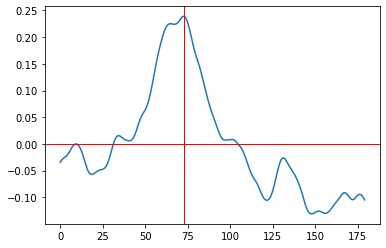

73
2


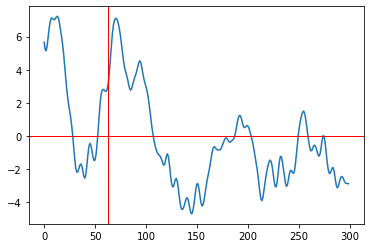

tensor([[0.1415, 0.8585],
        [0.4068, 0.5932],
        [0.4329, 0.5671],
        [0.8954, 0.1046],
        [0.5947, 0.4053],
        [0.8341, 0.1659],
        [0.8009, 0.1991]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  3 predict:  tensor(1, device='cuda:0')
0


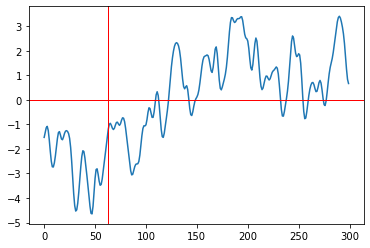

tensor([[0.3485, 0.6515],
        [0.8130, 0.1870],
        [0.8200, 0.1800],
        [0.6647, 0.3353],
        [0.3269, 0.6731],
        [0.5151, 0.4849],
        [0.7901, 0.2099]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  1 predict:  tensor(5, device='cuda:0')
1


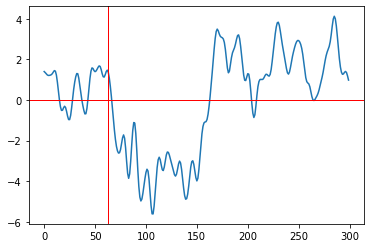

tensor([[0.3032, 0.6968],
        [0.1302, 0.8698],
        [0.3993, 0.6007],
        [0.3328, 0.6672],
        [0.3237, 0.6763],
        [0.1157, 0.8843],
        [0.3291, 0.6709]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  2 predict:  tensor(6, device='cuda:0')
2


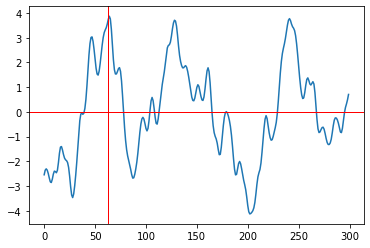

tensor([[0.6612, 0.3387],
        [0.2097, 0.7903],
        [0.0675, 0.9325],
        [0.5658, 0.4342],
        [0.2406, 0.7594],
        [0.2715, 0.7285],
        [0.2452, 0.7548]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  3 predict:  tensor(3, device='cuda:0')
6


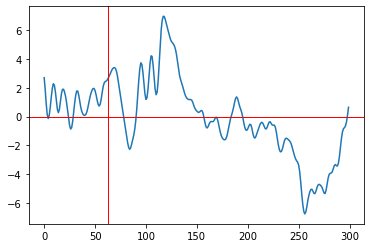

tensor([[0.8515, 0.1485],
        [0.6475, 0.3525],
        [0.4589, 0.5411],
        [0.0996, 0.9004],
        [0.3099, 0.6901],
        [0.3176, 0.6824],
        [0.3269, 0.6731]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  7 predict:  tensor(4, device='cuda:0')
3


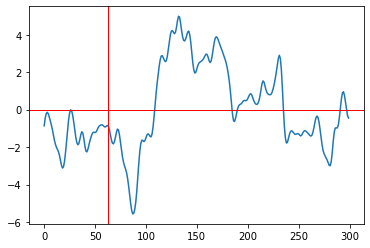

tensor([[0.1640, 0.8360],
        [0.6944, 0.3056],
        [0.5264, 0.4736],
        [0.1204, 0.8796],
        [0.5415, 0.4585],
        [0.2621, 0.7379],
        [0.8363, 0.1637]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  4 predict:  tensor(4, device='cuda:0')
5


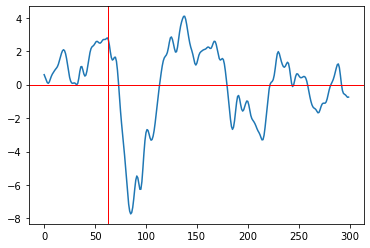

tensor([[0.3329, 0.6671],
        [0.1295, 0.8705],
        [0.4071, 0.5929],
        [0.4350, 0.5650],
        [0.2592, 0.7408],
        [0.0588, 0.9412],
        [0.5928, 0.4072]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  6 predict:  tensor(6, device='cuda:0')
2


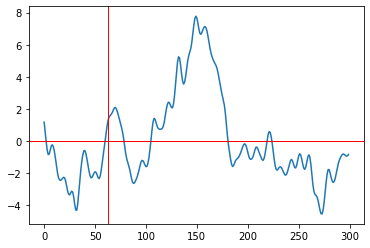

tensor([[0.5028, 0.4972],
        [0.6553, 0.3447],
        [0.3517, 0.6483],
        [0.3604, 0.6396],
        [0.4579, 0.5421],
        [0.8013, 0.1987],
        [0.7727, 0.2273]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  3 predict:  tensor(3, device='cuda:0')
2


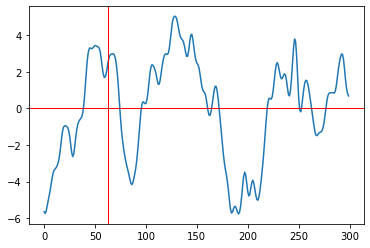

tensor([[0.3978, 0.6022],
        [0.6051, 0.3949],
        [0.0164, 0.9836],
        [0.2113, 0.7887],
        [0.3707, 0.6293],
        [0.5875, 0.4125],
        [0.6010, 0.3990]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  3 predict:  tensor(3, device='cuda:0')
3


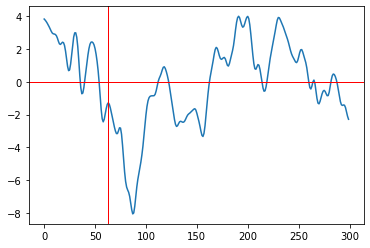

tensor([[0.3271, 0.6729],
        [0.1864, 0.8136],
        [0.1094, 0.8906],
        [0.0965, 0.9035],
        [0.2747, 0.7253],
        [0.1689, 0.8311],
        [0.2097, 0.7903]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  4 predict:  tensor(4, device='cuda:0')
4


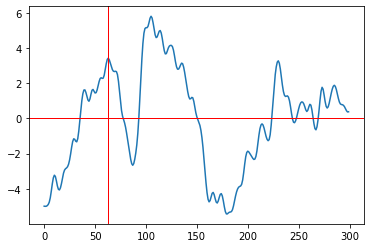

tensor([[0.4135, 0.5865],
        [0.6966, 0.3034],
        [0.3713, 0.6287],
        [0.9159, 0.0841],
        [0.6413, 0.3587],
        [0.6561, 0.3439],
        [0.8179, 0.1821]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  5 predict:  tensor(3, device='cuda:0')
1


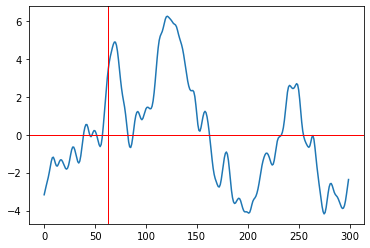

tensor([[0.3908, 0.6092],
        [0.5693, 0.4307],
        [0.7850, 0.2150],
        [0.7498, 0.2502],
        [0.7268, 0.2732],
        [0.5878, 0.4122],
        [0.4614, 0.5386]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  2 predict:  tensor(1, device='cuda:0')
6


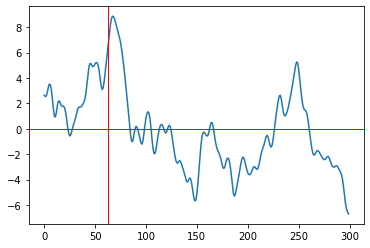

tensor([[0.3899, 0.6101],
        [0.2309, 0.7691],
        [0.5160, 0.4840],
        [0.2047, 0.7953],
        [0.6175, 0.3825],
        [0.5806, 0.4194],
        [0.2200, 0.7800]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  7 predict:  tensor(4, device='cuda:0')
6


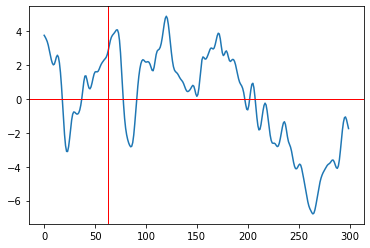

tensor([[0.4641, 0.5359],
        [0.4269, 0.5731],
        [0.2532, 0.7468],
        [0.3062, 0.6938],
        [0.6150, 0.3850],
        [0.3363, 0.6637],
        [0.1290, 0.8710]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  7 predict:  tensor(7, device='cuda:0')
0


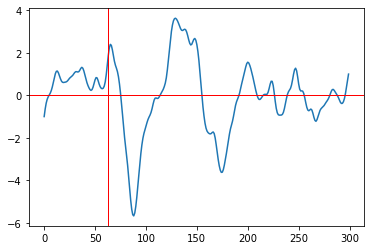

tensor([[0.4917, 0.5083],
        [0.9167, 0.0833],
        [0.4195, 0.5805],
        [0.6367, 0.3633],
        [0.4385, 0.5615],
        [0.7321, 0.2679],
        [0.9076, 0.0924]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  1 predict:  tensor(3, device='cuda:0')
0


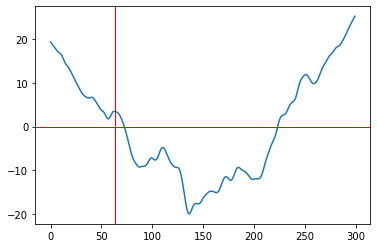

tensor([[0.7581, 0.2419],
        [0.5609, 0.4391],
        [0.3995, 0.6005],
        [0.4474, 0.5526],
        [0.3986, 0.6014],
        [0.5531, 0.4469],
        [0.8268, 0.1732]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  1 predict:  tensor(5, device='cuda:0')
1


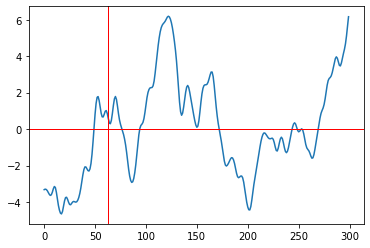

tensor([[0.3922, 0.6078],
        [0.2677, 0.7323],
        [0.8093, 0.1907],
        [0.4103, 0.5897],
        [0.3819, 0.6181],
        [0.7672, 0.2328],
        [0.4526, 0.5474]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  2 predict:  tensor(2, device='cuda:0')
2


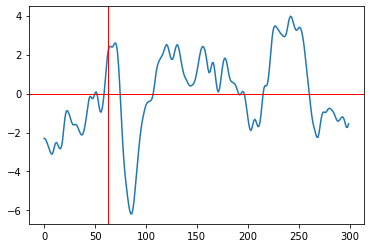

tensor([[0.5328, 0.4672],
        [0.4297, 0.5703],
        [0.4870, 0.5130],
        [0.4409, 0.5591],
        [0.3374, 0.6626],
        [0.5337, 0.4663],
        [0.5447, 0.4553]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  3 predict:  tensor(5, device='cuda:0')
3


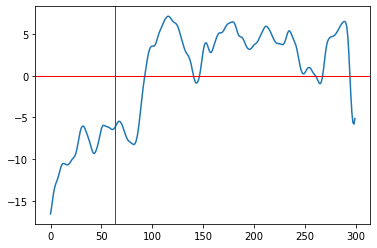

tensor([[0.6371, 0.3629],
        [0.4726, 0.5274],
        [0.6964, 0.3036],
        [0.7052, 0.2948],
        [0.4970, 0.5030],
        [0.4615, 0.5385],
        [0.5991, 0.4009]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  4 predict:  tensor(6, device='cuda:0')
4


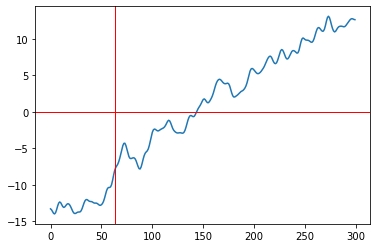

tensor([[0.2551, 0.7449],
        [0.3545, 0.6455],
        [0.4653, 0.5347],
        [0.6905, 0.3095],
        [0.7253, 0.2747],
        [0.5489, 0.4511],
        [0.6337, 0.3663]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  5 predict:  tensor(1, device='cuda:0')
2


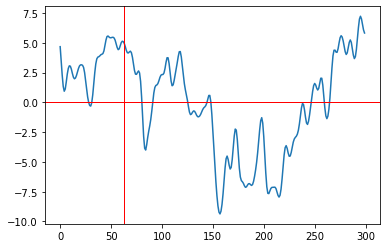

tensor([[0.3356, 0.6644],
        [0.4686, 0.5314],
        [0.3411, 0.6589],
        [0.5838, 0.4162],
        [0.7765, 0.2235],
        [0.3740, 0.6260],
        [0.5135, 0.4865]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  3 predict:  tensor(1, device='cuda:0')
6


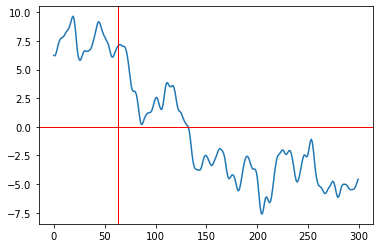

tensor([[0.4409, 0.5591],
        [0.5838, 0.4162],
        [0.5111, 0.4889],
        [0.6433, 0.3567],
        [0.4008, 0.5992],
        [0.4504, 0.5496],
        [0.7239, 0.2761]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  7 predict:  tensor(5, device='cuda:0')
0


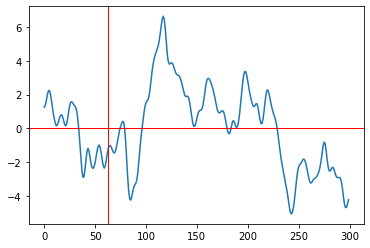

tensor([[0.2045, 0.7955],
        [0.7037, 0.2963],
        [0.3501, 0.6499],
        [0.5267, 0.4733],
        [0.6813, 0.3187],
        [0.7284, 0.2716],
        [0.4141, 0.5859]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  1 predict:  tensor(1, device='cuda:0')
1


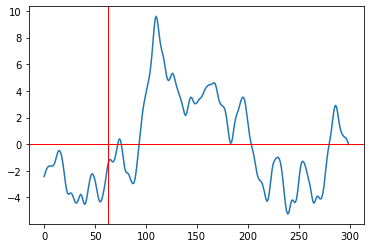

tensor([[0.4475, 0.5525],
        [0.7015, 0.2985],
        [0.3698, 0.6302],
        [0.5348, 0.4652],
        [0.4546, 0.5454],
        [0.2058, 0.7942],
        [0.5550, 0.4450]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  2 predict:  tensor(6, device='cuda:0')
4


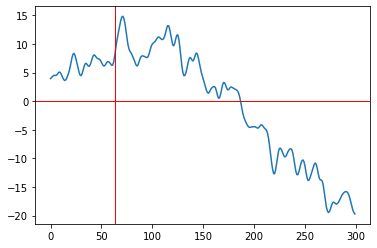

tensor([[0.4197, 0.5803],
        [0.7000, 0.3000],
        [0.7137, 0.2863],
        [0.8253, 0.1747],
        [0.3318, 0.6682],
        [0.5210, 0.4790],
        [0.5215, 0.4785]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  5 predict:  tensor(5, device='cuda:0')
5


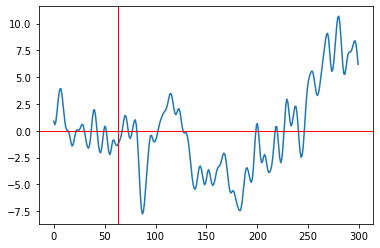

tensor([[0.6030, 0.3970],
        [0.2411, 0.7589],
        [0.5988, 0.4012],
        [0.5379, 0.4621],
        [0.7031, 0.2969],
        [0.6935, 0.3065],
        [0.2604, 0.7396]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  6 predict:  tensor(2, device='cuda:0')
6


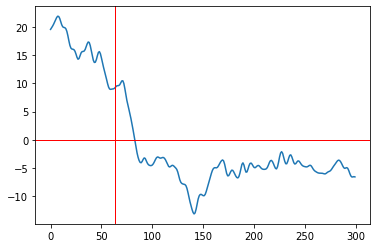

tensor([[0.4759, 0.5241],
        [0.6011, 0.3989],
        [0.8000, 0.2000],
        [0.5321, 0.4679],
        [0.5872, 0.4128],
        [0.4267, 0.5733],
        [0.3643, 0.6357]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  7 predict:  tensor(7, device='cuda:0')
0


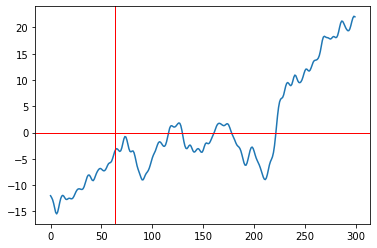

tensor([[0.6403, 0.3597],
        [0.2535, 0.7465],
        [0.7916, 0.2084],
        [0.3754, 0.6246],
        [0.5232, 0.4768],
        [0.5553, 0.4447],
        [0.5137, 0.4863]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  1 predict:  tensor(2, device='cuda:0')
4


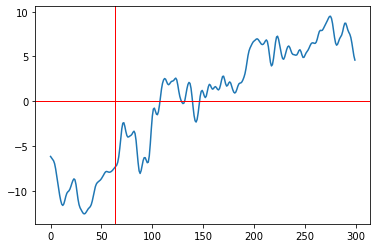

tensor([[0.4747, 0.5253],
        [0.7281, 0.2719],
        [0.6217, 0.3783],
        [0.6869, 0.3131],
        [0.4922, 0.5078],
        [0.5938, 0.4062],
        [0.5665, 0.4335]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  5 predict:  tensor(1, device='cuda:0')
4


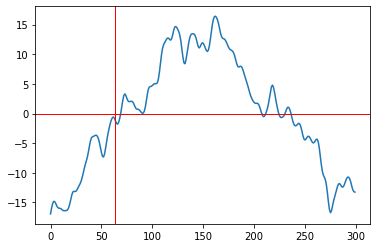

tensor([[0.7947, 0.2053],
        [0.6103, 0.3897],
        [0.4113, 0.5887],
        [0.3867, 0.6133],
        [0.4934, 0.5066],
        [0.5693, 0.4307],
        [0.1931, 0.8069]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  5 predict:  tensor(7, device='cuda:0')
score: 0.36666666666666664


In [51]:
import numpy as np
from scipy.signal import butter, lfilter, sosfiltfilt
import time
import os, glob
import hdf5storage
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import joblib
import shutil
from datetime import datetime
import socket
from scipy import signal
import matplotlib.pyplot as plt
from keras.models import load_model
import torch
import torch.nn as nn
from torch import optim
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CNN().to(DEVICE)

criterion = nn.BCELoss()
lr = 1e-5
# 더 천천히 모델은 분석 하는것 
optimizer = optim.Adam(model.parameters(), lr=lr)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        conv1 = nn.Conv1d(7, 3, 3, 1, padding=True) # 1, 6 은 임의로 한것
        max_pool = nn.MaxPool1d(4)
        self.bn1 = nn.BatchNorm1d(3)
        fc1 = nn.Linear(3*1*45, 2) # fully connected layer 1번 
        
        self.conv = nn.Sequential(
            conv1,  # N x 7 x 180 -> N x 3 x 180
            self.bn1,
            nn.ReLU(),
            max_pool,  # N x 3 x 180 -> N x 3 x 45

        )
        
        self.fc = nn.Sequential(
            fc1,  # N x 1024 -> N x 32
            nn.Softmax()  # 이건 분류 할때 사용 한거  out 이 1개일땐 다른거 쓰면 
        )

    def forward(self, x):
        x = self.conv(x)
        dim = 1
        for d in x.size()[1:]: #  N x 16 x 1 x 128
            dim = dim * d
            
        x = x.view(-1, dim)
        x = self.fc(x)
        return x
            
Classifier_path = 'D:\\P300_biosemi_55\\Model\\Bio\\'
classifier_list = sorted(glob.glob(Classifier_path + '*.pt'), key=os.path.getmtime, reverse=True)
weight_list = sorted(glob.glob(Classifier_path + 'Weight\\*.pt'), key=os.path.getmtime, reverse=True)
print(classifier_list[0])
model = torch.load(classifier_list[0])
model.load_state_dict(torch.load(weight_list[0]))

# filtering bandwidth
low, high = 0.23, 30

    
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y

def Standardization(Epochs):
    for i in range(Epochs.shape[1]):
        Epochs[:,i,:] = np.subtract(Epochs[:,i,:], np.mean(Epochs[:,i,:]))
        Epochs[:,i,:] = Epochs[:,i,:] / np.std(Epochs[:,i,:])
    
    return Epochs    
    
def Epoching(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
            for i in range(nChannel):
                Epochs[j,i,:] = Epochs[j,i,:] - np.mean(Epochs[j,i,:])
                
#         Epochs = Standardization(Epochs)
        Epochs_Aver = np.mean(Epochs, axis=0)

        return Epochs_Aver
def Balancing_DataSet(Epochs, size):
        Epochs_New = np.zeros((size, Epochs.shape[1], Epochs.shape[2]))
    
        index = np.random.choice(Epochs.shape[0], size = size, replace = False)
    
        Epochs_New = Epochs[index, :, :]
    
        return Epochs_New
def Epoching_v(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
        return [Epochs, Num[0]]    
def plotGraph_v(filename):


        mat = hdf5storage.loadmat(filename)
        channelNames = mat['channelNames']
        eegData = mat['eegData']
        samplingFreq = mat['samplingFreq']
        samplingFreq = samplingFreq[0,0]
        stims = mat['stims']
        channelNum = channelNames.shape
        channelNum = channelNum[1]
        eegData = np.transpose(eegData)
        
        
        #Bandpass Filter
        eegData = butter_bandpass_filter(eegData, 0.23, 30, samplingFreq, order=4)
    
        #Epoching
        epochSampleNum = int(np.floor(0.6 * samplingFreq))
        offset = int(np.floor(0.2 * samplingFreq)) 
        baseline = int(np.floor(0.8 * samplingFreq)) 
        [EpochsT, NumT] = Epoching_v(eegData, stims, 1, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        [EpochsN, NumN] = Epoching_v(eegData, stims, 0, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        
        EpochsN_New = Balancing_DataSet(EpochsN, NumT)
        
        EpochsT = Standardization(EpochsT)
        EpochsN = Standardization(EpochsN_New)
        Target_All=np.mean(EpochsT,axis=0)
        
        return [EpochsT[:,:,:], EpochsN[:,:,:]]  

    
def main():
     #--------------------------------------------------------------    
        root = 'D:\\VR300_20\\S'
        T_all_V= np.zeros((8*210,7,180))
        N_all_V= np.zeros((8*210,7,180))
        count = 0

        for i in np.arange(1,20):
            if i % 2 == 1: 
                if (i==7 or i==13):
                    continue
                if(i<10):
                    count = count + 1
                    root_VR = root + '0' + str(i)+'/Training/mat/'
                    current_list = sorted(glob.glob(root_VR + '*.mat'), key=os.path.getmtime, reverse=True)
                    root_VR = current_list[0]
                else:
                    count = count + 1
                    root_VR = root + str(i)+'/Training/mat/'
                    current_list = sorted(glob.glob(root_VR + '*.mat'), key=os.path.getmtime, reverse=True)
                    root_VR = current_list[0]
                [T_all_V[210*(count-1):210*count,:,:],N_all_V[210*(count-1):210*count,:,:]]=plotGraph_v(root_VR)
    #-------------------------------------------------------
        Target_All=np.mean(T_all_V,axis=0)
        max_I=0
        for k in np.arange(0,7):
            if k == 2:
                a=k+1
                print(a)
                plt.plot(Target_All[k,:])
                plt.axvline(x=np.argmax(Target_All[k,:]), color='r', linewidth=1)
                max_I=np.argmax(Target_All[k,:])
                max_V =max(Target_All[k,:])
                plt.axhline(y=0, color='r', linewidth=1)
                plt.show()
        print(max_I)
        root_path = "D:\\VR300_20\\S02\\"
        Target_All=np.mean(T_all_V,axis=0)
        mat_path = root_path + 'Online\\mat\\'
        current_list = sorted(glob.glob(mat_path + '*.mat'), key=os.path.getmtime)
        score = 0
        wrong_ans = []
        
        target_val = nontarget_val = 0
        
        for mat_file in current_list:
            #print(mat_file)
            ans = mat_file[-5]
            
            mat = hdf5storage.loadmat(mat_file)
            channelNames = mat['channelNames']
            eegData = mat['eegData']
            samplingFreq = mat['samplingFreq']
            samplingFreq = samplingFreq[0,0]
            stims = mat['stims']
            channelNum = channelNames.shape
            channelNum = channelNum[1]
            eegData = np.transpose(eegData)
            buttonNum = 7
            
            #Bandpass Filter
            eegData = butter_bandpass_filter(eegData, low, high, samplingFreq, order=4)

            #Epoching
            epochSampleNum = int(np.floor( 1* samplingFreq))
            offset = int(np.floor(0 * samplingFreq))
            baseline = int(np.floor(1 * samplingFreq))
            
            ####### averaging whole epochs
            Epochs_Aver = np.zeros((buttonNum, channelNum, epochSampleNum))
            
            
            for i in np.arange(0,7):
                Epochs_Aver[i] = Epoching(eegData, stims, (i+1), samplingFreq, channelNum, epochSampleNum, offset, baseline)
            #max_I np.mean(T_all_V,axis=0)
    #*********************************************************
            hz=180

            target_data = Epochs_Aver[int(ans)-1,:,:]
            print(int(ans)-1)
            mat = np.zeros((2, hz))
     
            plt.plot(np.mean(Epochs_Aver[int(ans)-1,:,:],axis=0))
            plt.axvline(x=np.argmax(Target_All[k,:]), color='r', linewidth=1)
            max_I=np.argmax(Target_All[k,:])
            max_V =max(Target_All[k,:])
            plt.axhline(y=0, color='r', linewidth=1)
            plt.show()
            for j in np.arange(0,7):
                mat[0] = Target_All[j,:]
                coef = np.zeros(80)
                q=0
                for b in np.arange(0,80):
                    mat[1] = target_data[j,0*hz+1*b:1*hz+1*(b)]
                    corrcoef = np.corrcoef(mat)
                    coef[q] = corrcoef[0,1]
                    q=q+1
                index = np.argmax(np.abs(coef))
            #실시간 맞춰주기
                start = 0*hz+1*index
                finish = 1*hz+1*(index)
    #*********************************************************             
            b=torch.Tensor(Epochs_Aver[:,:,start:finish].reshape(7,7,180)).to(DEVICE)
            test_output=model(b)
            test_output[:, 1].max(dim=0)
            print(test_output)
            predict= test_output[:, 1].max(dim=0)[1]+1
            
            if int(ans) == int(predict): 
                score = score + 1
            else:
                wrong_ans.append(mat_file[mat_file.rfind('\\')+1:mat_file.rfind('_')])
            print('order: ', ans, 'predict: ', predict)
            
        #print('wrong answer', wrong_ans)
        print('score:', score/(len(wrong_ans)+score))

if __name__ == "__main__":
    main()

D:\P300_biosemi_55\Model\Bio\ZERO_Bio.pt
3


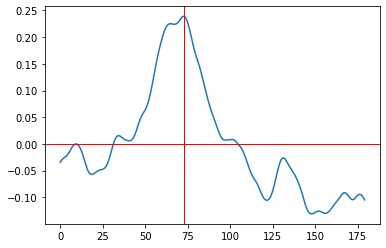

73
2


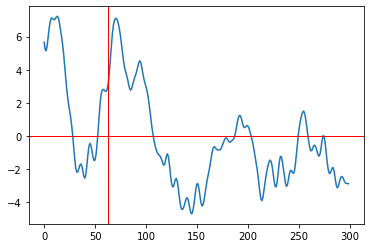

tensor([[0.1415, 0.8585],
        [0.4068, 0.5932],
        [0.4329, 0.5671],
        [0.8954, 0.1046],
        [0.5947, 0.4053],
        [0.8341, 0.1659],
        [0.8009, 0.1991]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  3 predict:  tensor(1, device='cuda:0')
0


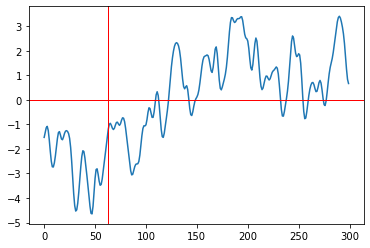

tensor([[0.3485, 0.6515],
        [0.8130, 0.1870],
        [0.8200, 0.1800],
        [0.6647, 0.3353],
        [0.3269, 0.6731],
        [0.5151, 0.4849],
        [0.7901, 0.2099]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  1 predict:  tensor(5, device='cuda:0')
1


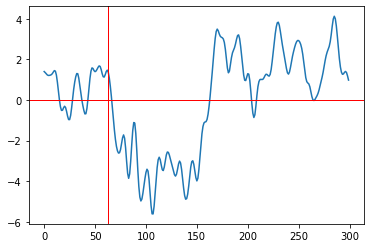

tensor([[0.3032, 0.6968],
        [0.1302, 0.8698],
        [0.3993, 0.6007],
        [0.3328, 0.6672],
        [0.3237, 0.6763],
        [0.1157, 0.8843],
        [0.3291, 0.6709]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  2 predict:  tensor(6, device='cuda:0')
2


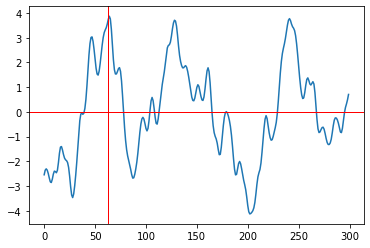

tensor([[0.6612, 0.3387],
        [0.2097, 0.7903],
        [0.0675, 0.9325],
        [0.5658, 0.4342],
        [0.2406, 0.7594],
        [0.2715, 0.7285],
        [0.2452, 0.7548]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  3 predict:  tensor(3, device='cuda:0')
6


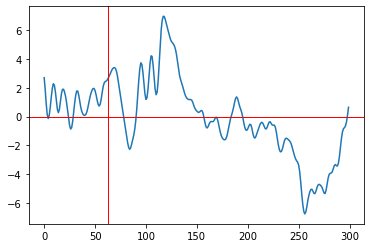

tensor([[0.8515, 0.1485],
        [0.6475, 0.3525],
        [0.4589, 0.5411],
        [0.0996, 0.9004],
        [0.3099, 0.6901],
        [0.3176, 0.6824],
        [0.3269, 0.6731]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  7 predict:  tensor(4, device='cuda:0')
3


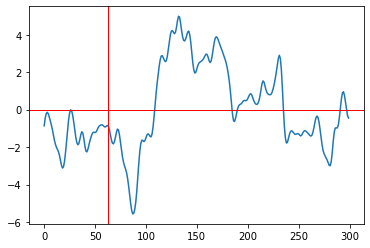

tensor([[0.1640, 0.8360],
        [0.6944, 0.3056],
        [0.5264, 0.4736],
        [0.1204, 0.8796],
        [0.5415, 0.4585],
        [0.2621, 0.7379],
        [0.8363, 0.1637]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  4 predict:  tensor(4, device='cuda:0')
5


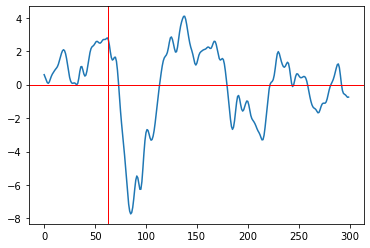

tensor([[0.3329, 0.6671],
        [0.1295, 0.8705],
        [0.4071, 0.5929],
        [0.4350, 0.5650],
        [0.2592, 0.7408],
        [0.0588, 0.9412],
        [0.5928, 0.4072]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  6 predict:  tensor(6, device='cuda:0')
2


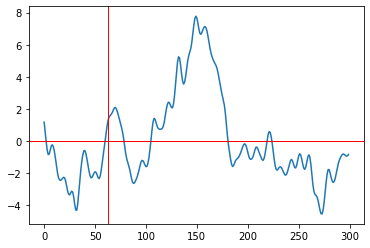

tensor([[0.5028, 0.4972],
        [0.6553, 0.3447],
        [0.3517, 0.6483],
        [0.3604, 0.6396],
        [0.4579, 0.5421],
        [0.8013, 0.1987],
        [0.7727, 0.2273]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  3 predict:  tensor(3, device='cuda:0')
2


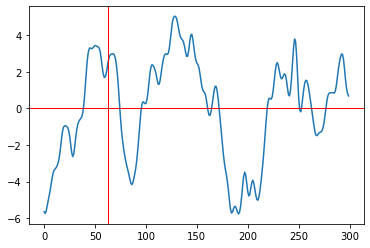

tensor([[0.3978, 0.6022],
        [0.6051, 0.3949],
        [0.0164, 0.9836],
        [0.2113, 0.7887],
        [0.3707, 0.6293],
        [0.5875, 0.4125],
        [0.6010, 0.3990]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  3 predict:  tensor(3, device='cuda:0')
3


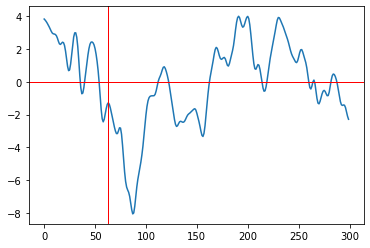

tensor([[0.3271, 0.6729],
        [0.1864, 0.8136],
        [0.1094, 0.8906],
        [0.0965, 0.9035],
        [0.2747, 0.7253],
        [0.1689, 0.8311],
        [0.2097, 0.7903]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  4 predict:  tensor(4, device='cuda:0')
4


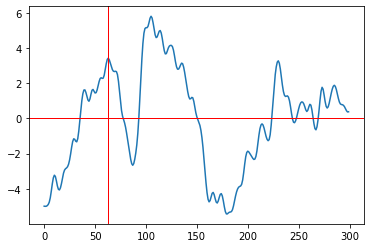

tensor([[0.4135, 0.5865],
        [0.6966, 0.3034],
        [0.3713, 0.6287],
        [0.9159, 0.0841],
        [0.6413, 0.3587],
        [0.6561, 0.3439],
        [0.8179, 0.1821]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  5 predict:  tensor(3, device='cuda:0')
1


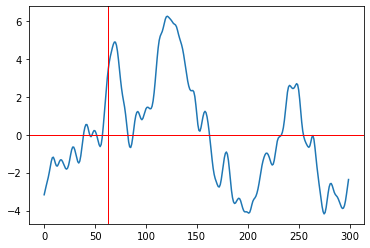

tensor([[0.3908, 0.6092],
        [0.5693, 0.4307],
        [0.7850, 0.2150],
        [0.7498, 0.2502],
        [0.7268, 0.2732],
        [0.5878, 0.4122],
        [0.4614, 0.5386]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  2 predict:  tensor(1, device='cuda:0')
6


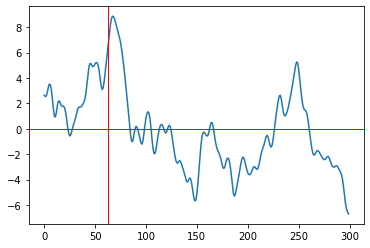

tensor([[0.3899, 0.6101],
        [0.2309, 0.7691],
        [0.5160, 0.4840],
        [0.2047, 0.7953],
        [0.6175, 0.3825],
        [0.5806, 0.4194],
        [0.2200, 0.7800]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  7 predict:  tensor(4, device='cuda:0')
6


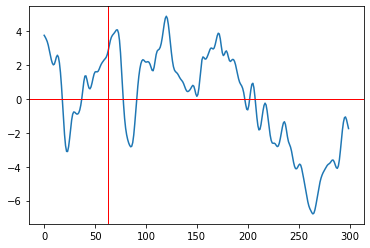

tensor([[0.4641, 0.5359],
        [0.4269, 0.5731],
        [0.2532, 0.7468],
        [0.3062, 0.6938],
        [0.6150, 0.3850],
        [0.3363, 0.6637],
        [0.1290, 0.8710]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  7 predict:  tensor(7, device='cuda:0')
0


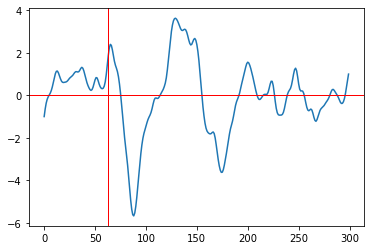

tensor([[0.4917, 0.5083],
        [0.9167, 0.0833],
        [0.4195, 0.5805],
        [0.6367, 0.3633],
        [0.4385, 0.5615],
        [0.7321, 0.2679],
        [0.9076, 0.0924]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  1 predict:  tensor(3, device='cuda:0')
0


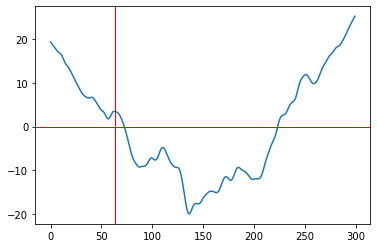

tensor([[0.7581, 0.2419],
        [0.5609, 0.4391],
        [0.3995, 0.6005],
        [0.4474, 0.5526],
        [0.3986, 0.6014],
        [0.5531, 0.4469],
        [0.8268, 0.1732]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  1 predict:  tensor(5, device='cuda:0')
1


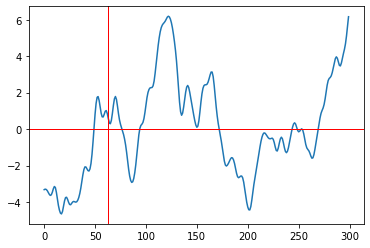

tensor([[0.3922, 0.6078],
        [0.2677, 0.7323],
        [0.8093, 0.1907],
        [0.4103, 0.5897],
        [0.3819, 0.6181],
        [0.7672, 0.2328],
        [0.4526, 0.5474]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  2 predict:  tensor(2, device='cuda:0')
2


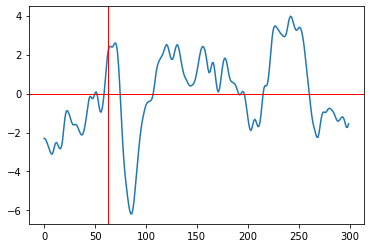

tensor([[0.5328, 0.4672],
        [0.4297, 0.5703],
        [0.4870, 0.5130],
        [0.4409, 0.5591],
        [0.3374, 0.6626],
        [0.5337, 0.4663],
        [0.5447, 0.4553]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  3 predict:  tensor(5, device='cuda:0')
3


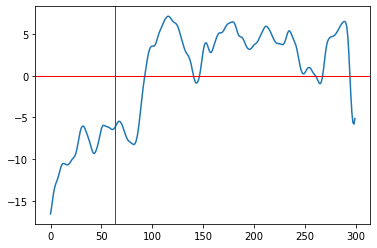

tensor([[0.6371, 0.3629],
        [0.4726, 0.5274],
        [0.6964, 0.3036],
        [0.7052, 0.2948],
        [0.4970, 0.5030],
        [0.4615, 0.5385],
        [0.5991, 0.4009]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  4 predict:  tensor(6, device='cuda:0')
4


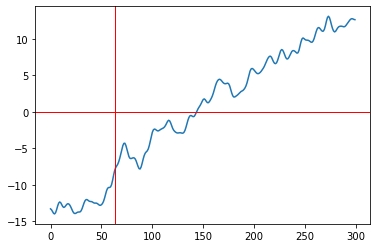

tensor([[0.2551, 0.7449],
        [0.3545, 0.6455],
        [0.4653, 0.5347],
        [0.6905, 0.3095],
        [0.7253, 0.2747],
        [0.5489, 0.4511],
        [0.6337, 0.3663]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  5 predict:  tensor(1, device='cuda:0')
2


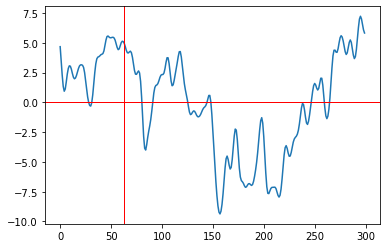

tensor([[0.3356, 0.6644],
        [0.4686, 0.5314],
        [0.3411, 0.6589],
        [0.5838, 0.4162],
        [0.7765, 0.2235],
        [0.3740, 0.6260],
        [0.5135, 0.4865]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  3 predict:  tensor(1, device='cuda:0')
6


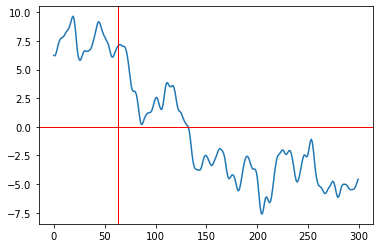

tensor([[0.4409, 0.5591],
        [0.5838, 0.4162],
        [0.5111, 0.4889],
        [0.6433, 0.3567],
        [0.4008, 0.5992],
        [0.4504, 0.5496],
        [0.7239, 0.2761]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  7 predict:  tensor(5, device='cuda:0')
0


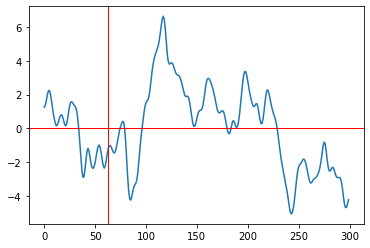

tensor([[0.2045, 0.7955],
        [0.7037, 0.2963],
        [0.3501, 0.6499],
        [0.5267, 0.4733],
        [0.6813, 0.3187],
        [0.7284, 0.2716],
        [0.4141, 0.5859]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  1 predict:  tensor(1, device='cuda:0')
1


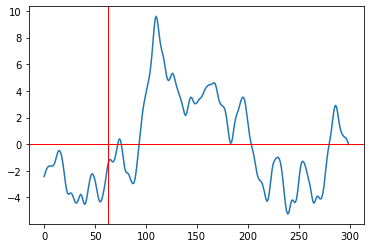

tensor([[0.4475, 0.5525],
        [0.7015, 0.2985],
        [0.3698, 0.6302],
        [0.5348, 0.4652],
        [0.4546, 0.5454],
        [0.2058, 0.7942],
        [0.5550, 0.4450]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  2 predict:  tensor(6, device='cuda:0')
4


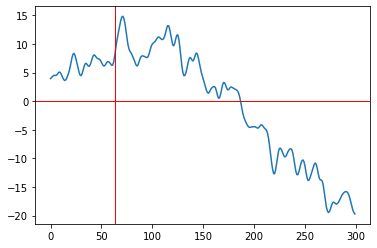

tensor([[0.4197, 0.5803],
        [0.7000, 0.3000],
        [0.7137, 0.2863],
        [0.8253, 0.1747],
        [0.3318, 0.6682],
        [0.5210, 0.4790],
        [0.5215, 0.4785]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  5 predict:  tensor(5, device='cuda:0')
5


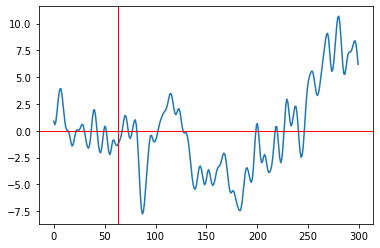

tensor([[0.6030, 0.3970],
        [0.2411, 0.7589],
        [0.5988, 0.4012],
        [0.5379, 0.4621],
        [0.7031, 0.2969],
        [0.6935, 0.3065],
        [0.2604, 0.7396]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  6 predict:  tensor(2, device='cuda:0')
6


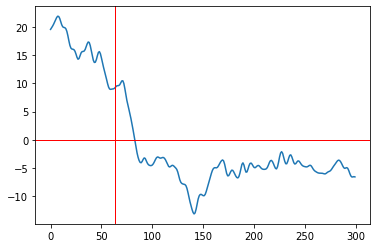

tensor([[0.4759, 0.5241],
        [0.6011, 0.3989],
        [0.8000, 0.2000],
        [0.5321, 0.4679],
        [0.5872, 0.4128],
        [0.4267, 0.5733],
        [0.3643, 0.6357]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  7 predict:  tensor(7, device='cuda:0')
0


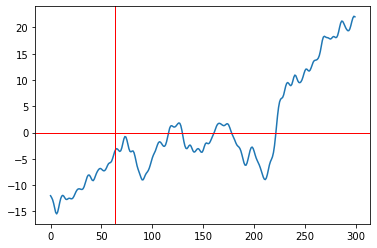

tensor([[0.6403, 0.3597],
        [0.2535, 0.7465],
        [0.7916, 0.2084],
        [0.3754, 0.6246],
        [0.5232, 0.4768],
        [0.5553, 0.4447],
        [0.5137, 0.4863]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  1 predict:  tensor(2, device='cuda:0')
4


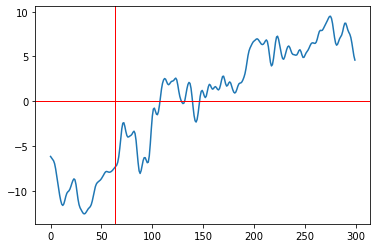

tensor([[0.4747, 0.5253],
        [0.7281, 0.2719],
        [0.6217, 0.3783],
        [0.6869, 0.3131],
        [0.4922, 0.5078],
        [0.5938, 0.4062],
        [0.5665, 0.4335]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  5 predict:  tensor(1, device='cuda:0')
4


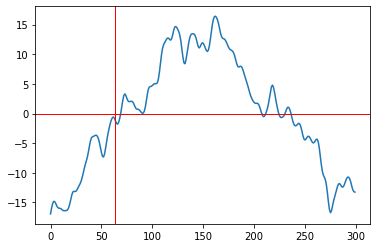

tensor([[0.7947, 0.2053],
        [0.6103, 0.3897],
        [0.4113, 0.5887],
        [0.3867, 0.6133],
        [0.4934, 0.5066],
        [0.5693, 0.4307],
        [0.1931, 0.8069]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  5 predict:  tensor(7, device='cuda:0')
score: 0.36666666666666664


In [75]:
import numpy as np
from scipy.signal import butter, lfilter, sosfiltfilt
import time
import os, glob
import hdf5storage
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import joblib
import shutil
from datetime import datetime
import socket
from scipy import signal
import matplotlib.pyplot as plt
from keras.models import load_model
import torch
import torch.nn as nn
from torch import optim
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CNN().to(DEVICE)

criterion = nn.BCELoss()
lr = 1e-5
# 더 천천히 모델은 분석 하는것 
optimizer = optim.Adam(model.parameters(), lr=lr)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        conv1 = nn.Conv1d(7, 3, 3, 1, padding=True) # 1, 6 은 임의로 한것
        max_pool = nn.MaxPool1d(4)
        self.bn1 = nn.BatchNorm1d(3)
        fc1 = nn.Linear(3*1*45, 2) # fully connected layer 1번 
        
        self.conv = nn.Sequential(
            conv1,  # N x 7 x 180 -> N x 3 x 180
            self.bn1,
            nn.ReLU(),
            max_pool,  # N x 3 x 180 -> N x 3 x 45

        )
        
        self.fc = nn.Sequential(
            fc1,  # N x 1024 -> N x 32
            nn.Softmax()  # 이건 분류 할때 사용 한거  out 이 1개일땐 다른거 쓰면 
        )

    def forward(self, x):
        x = self.conv(x)
        dim = 1
        for d in x.size()[1:]: #  N x 16 x 1 x 128
            dim = dim * d
            
        x = x.view(-1, dim)
        x = self.fc(x)
        return x
            
Classifier_path = 'D:\\P300_biosemi_55\\Model\\Bio\\'
classifier_list = sorted(glob.glob(Classifier_path + '*.pt'), key=os.path.getmtime, reverse=True)
weight_list = sorted(glob.glob(Classifier_path + 'Weight\\*.pt'), key=os.path.getmtime, reverse=True)
print(classifier_list[0])
model = torch.load(classifier_list[0])
model.load_state_dict(torch.load(weight_list[0]))

# filtering bandwidth
low, high = 0.23, 30

    
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y

def Standardization(Epochs):
    for i in range(Epochs.shape[1]):
        Epochs[:,i,:] = np.subtract(Epochs[:,i,:], np.mean(Epochs[:,i,:]))
        Epochs[:,i,:] = Epochs[:,i,:] / np.std(Epochs[:,i,:])
    
    return Epochs    
    
def Epoching(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
            for i in range(nChannel):
                Epochs[j,i,:] = Epochs[j,i,:] - np.mean(Epochs[j,i,:])
                
#         Epochs = Standardization(Epochs)
        Epochs_Aver = np.mean(Epochs, axis=0)

        return Epochs_Aver
def Balancing_DataSet(Epochs, size):
        Epochs_New = np.zeros((size, Epochs.shape[1], Epochs.shape[2]))
    
        index = np.random.choice(Epochs.shape[0], size = size, replace = False)
    
        Epochs_New = Epochs[index, :, :]
    
        return Epochs_New
def Epoching_v(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
        return [Epochs, Num[0]]    
def plotGraph_v(filename):


        mat = hdf5storage.loadmat(filename)
        channelNames = mat['channelNames']
        eegData = mat['eegData']
        samplingFreq = mat['samplingFreq']
        samplingFreq = samplingFreq[0,0]
        stims = mat['stims']
        channelNum = channelNames.shape
        channelNum = channelNum[1]
        eegData = np.transpose(eegData)
        
        
        #Bandpass Filter
        eegData = butter_bandpass_filter(eegData, 0.23, 30, samplingFreq, order=4)
    
        #Epoching
        epochSampleNum = int(np.floor(0.6 * samplingFreq))
        offset = int(np.floor(0.2 * samplingFreq)) 
        baseline = int(np.floor(0.8 * samplingFreq)) 
        [EpochsT, NumT] = Epoching_v(eegData, stims, 1, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        [EpochsN, NumN] = Epoching_v(eegData, stims, 0, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        
        EpochsN_New = Balancing_DataSet(EpochsN, NumT)
        
        EpochsT = Standardization(EpochsT)
        EpochsN = Standardization(EpochsN_New)
        Target_All=np.mean(EpochsT,axis=0)
        
        return [EpochsT[:,:,:], EpochsN[:,:,:]]  

    
def main():
     #--------------------------------------------------------------    
        root = 'D:\\VR300_20\\S'
        T_all_V= np.zeros((8*210,7,180))
        N_all_V= np.zeros((8*210,7,180))
        count = 0

        for i in np.arange(1,20):
            if i % 2 == 1: 
                if (i==7 or i==13):
                    continue
                if(i<10):
                    count = count + 1
                    root_VR = root + '0' + str(i)+'/Training/mat/'
                    current_list = sorted(glob.glob(root_VR + '*.mat'), key=os.path.getmtime, reverse=True)
                    root_VR = current_list[0]
                else:
                    count = count + 1
                    root_VR = root + str(i)+'/Training/mat/'
                    current_list = sorted(glob.glob(root_VR + '*.mat'), key=os.path.getmtime, reverse=True)
                    root_VR = current_list[0]
                [T_all_V[210*(count-1):210*count,:,:],N_all_V[210*(count-1):210*count,:,:]]=plotGraph_v(root_VR)
    #-------------------------------------------------------
        Target_All=np.mean(T_all_V,axis=0)
        max_I=0
        for k in np.arange(0,7):
            if k == 2:
                a=k+1
                print(a)
                plt.plot(Target_All[k,:])
                plt.axvline(x=np.argmax(Target_All[k,:]), color='r', linewidth=1)
                max_I=np.argmax(Target_All[k,:])
                max_V =max(Target_All[k,:])
                plt.axhline(y=0, color='r', linewidth=1)
                plt.show()
        print(max_I)
        root_path = "D:\\VR300_20\\S02\\"
        Target_All=np.mean(T_all_V,axis=0)
        mat_path = root_path + 'Online\\mat\\'
        current_list = sorted(glob.glob(mat_path + '*.mat'), key=os.path.getmtime)
        score = 0
        wrong_ans = []
        
        target_val = nontarget_val = 0
        
        for mat_file in current_list:
            #print(mat_file)
            ans = mat_file[-5]
            
            mat = hdf5storage.loadmat(mat_file)
            channelNames = mat['channelNames']
            eegData = mat['eegData']
            samplingFreq = mat['samplingFreq']
            samplingFreq = samplingFreq[0,0]
            stims = mat['stims']
            channelNum = channelNames.shape
            channelNum = channelNum[1]
            eegData = np.transpose(eegData)
            buttonNum = 7
            
            #Bandpass Filter
            eegData = butter_bandpass_filter(eegData, low, high, samplingFreq, order=4)

            #Epoching
            epochSampleNum = int(np.floor( 1* samplingFreq))
            offset = int(np.floor(0 * samplingFreq))
            baseline = int(np.floor(1 * samplingFreq))
            
            ####### averaging whole epochs
            Epochs_Aver = np.zeros((buttonNum, channelNum, epochSampleNum))
            
            
            for i in np.arange(0,7):
                Epochs_Aver[i] = Epoching(eegData, stims, (i+1), samplingFreq, channelNum, epochSampleNum, offset, baseline)
            #max_I np.mean(T_all_V,axis=0)
    #*********************************************************
            hz=180

            target_data = Epochs_Aver[int(ans)-1,:,:]
            print(int(ans)-1)
            mat = np.zeros((2, hz))
     
            plt.plot(np.mean(Epochs_Aver[int(ans)-1,:,:],axis=0))
            plt.axvline(x=np.argmax(Target_All[k,:]), color='r', linewidth=1)
            max_I=np.argmax(Target_All[k,:])
            max_V =max(Target_All[k,:])
            plt.axhline(y=0, color='r', linewidth=1)
            plt.show()
            for j in np.arange(0,7):
                mat[0] = Target_All[j,:]
                coef = np.zeros(80)
                q=0
                for b in np.arange(0,80):
                    mat[1] = target_data[j,0*hz+1*b:1*hz+1*(b)]
                    corrcoef = np.corrcoef(mat)
                    coef[q] = corrcoef[0,1]
                    q=q+1
                index = np.argmax(np.abs(coef))
            #실시간 맞춰주기
                start = 0*hz+1*index
                finish = 1*hz+1*(index)
    #*********************************************************             
            b=torch.Tensor(Epochs_Aver[:,:,start:finish].reshape(7,7,180)).to(DEVICE)
            test_output=model(b)
            test_output[:, 1].max(dim=0)
            print(test_output)
            predict= test_output[:, 1].max(dim=0)[1]+1
            
            if int(ans) == int(predict): 
                score = score + 1
            else:
                wrong_ans.append(mat_file[mat_file.rfind('\\')+1:mat_file.rfind('_')])
            print('order: ', ans, 'predict: ', predict)
            
        #print('wrong answer', wrong_ans)
        print('score:', score/(len(wrong_ans)+score))

if __name__ == "__main__":
    main()

D:\P300_biosemi_55\Model\Bio\ZERO_Bio.pt
3


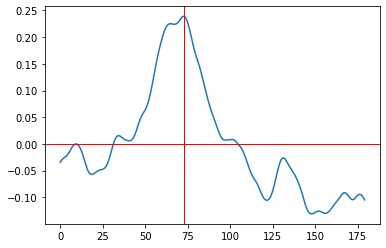

73
2


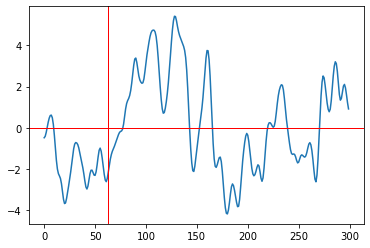

tensor([[0.3431, 0.6569],
        [0.8890, 0.1110],
        [0.1417, 0.8583],
        [0.4124, 0.5876],
        [0.6120, 0.3880],
        [0.4919, 0.5081],
        [0.2763, 0.7237]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  3 predict:  tensor(3, device='cuda:0')
0


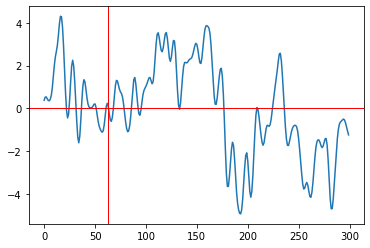

tensor([[0.1264, 0.8736],
        [0.6364, 0.3636],
        [0.7615, 0.2385],
        [0.5887, 0.4113],
        [0.6514, 0.3486],
        [0.8135, 0.1865],
        [0.4901, 0.5099]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  1 predict:  tensor(1, device='cuda:0')
1


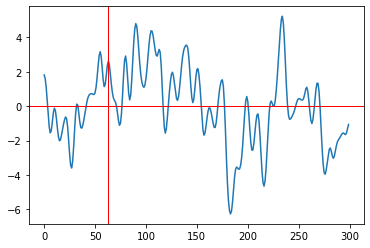

tensor([[0.3795, 0.6205],
        [0.2802, 0.7198],
        [0.3391, 0.6609],
        [0.4588, 0.5412],
        [0.6314, 0.3686],
        [0.2138, 0.7862],
        [0.8116, 0.1884]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  2 predict:  tensor(6, device='cuda:0')
5


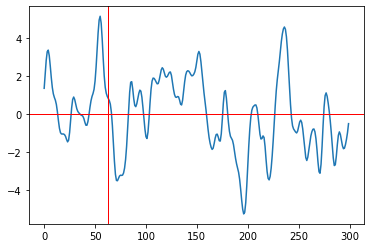

tensor([[0.3063, 0.6937],
        [0.5777, 0.4223],
        [0.3380, 0.6620],
        [0.6064, 0.3936],
        [0.6957, 0.3043],
        [0.1704, 0.8296],
        [0.6142, 0.3858]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  6 predict:  tensor(6, device='cuda:0')
3


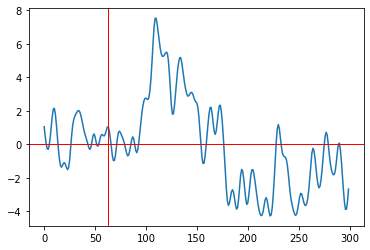

tensor([[0.9223, 0.0777],
        [0.6555, 0.3445],
        [0.3649, 0.6351],
        [0.7786, 0.2214],
        [0.8322, 0.1678],
        [0.4116, 0.5884],
        [0.6264, 0.3736]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  4 predict:  tensor(3, device='cuda:0')
1


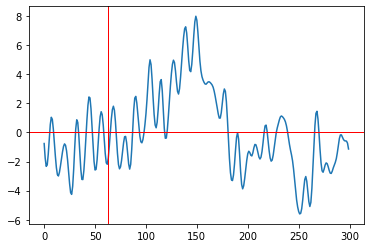

tensor([[0.5927, 0.4073],
        [0.7790, 0.2210],
        [0.2918, 0.7082],
        [0.6241, 0.3759],
        [0.4618, 0.5382],
        [0.6029, 0.3971],
        [0.7659, 0.2341]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  2 predict:  tensor(3, device='cuda:0')
4


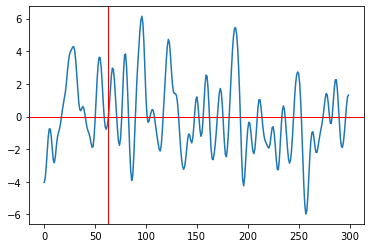

tensor([[0.4531, 0.5469],
        [0.5856, 0.4144],
        [0.4298, 0.5702],
        [0.7400, 0.2600],
        [0.4332, 0.5668],
        [0.4648, 0.5352],
        [0.8524, 0.1476]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  5 predict:  tensor(3, device='cuda:0')
3


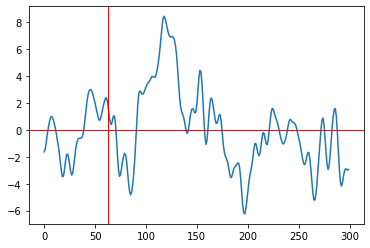

tensor([[0.5145, 0.4855],
        [0.5226, 0.4774],
        [0.6151, 0.3849],
        [0.0737, 0.9263],
        [0.4123, 0.5877],
        [0.2263, 0.7737],
        [0.5913, 0.4087]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  4 predict:  tensor(4, device='cuda:0')
5


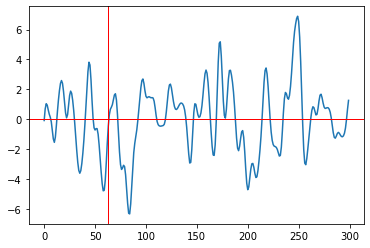

tensor([[0.5741, 0.4259],
        [0.7198, 0.2802],
        [0.3977, 0.6023],
        [0.4323, 0.5677],
        [0.5659, 0.4341],
        [0.2549, 0.7451],
        [0.6094, 0.3906]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  6 predict:  tensor(6, device='cuda:0')
0


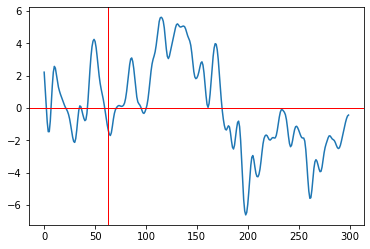

tensor([[0.0229, 0.9771],
        [0.8634, 0.1366],
        [0.7572, 0.2428],
        [0.9018, 0.0982],
        [0.5188, 0.4812],
        [0.8447, 0.1553],
        [0.2603, 0.7397]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  1 predict:  tensor(1, device='cuda:0')
3


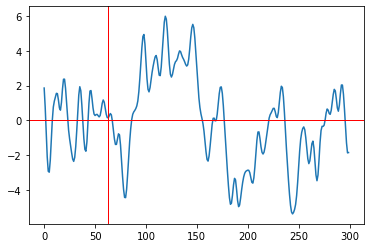

tensor([[0.7196, 0.2804],
        [0.7028, 0.2972],
        [0.7465, 0.2535],
        [0.0837, 0.9163],
        [0.3429, 0.6571],
        [0.7217, 0.2783],
        [0.6046, 0.3954]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  4 predict:  tensor(4, device='cuda:0')
5


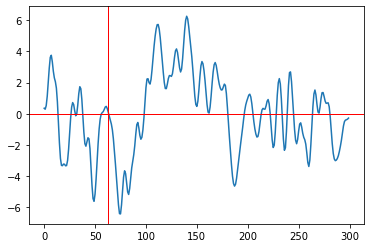

tensor([[0.4958, 0.5042],
        [0.9105, 0.0895],
        [0.7712, 0.2288],
        [0.4125, 0.5875],
        [0.5613, 0.4387],
        [0.5989, 0.4011],
        [0.2659, 0.7341]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  6 predict:  tensor(7, device='cuda:0')
4


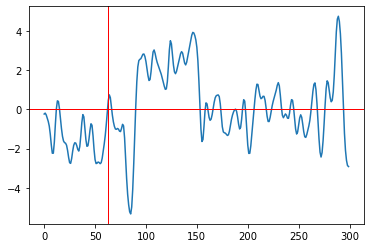

tensor([[0.6721, 0.3279],
        [0.1956, 0.8044],
        [0.4203, 0.5797],
        [0.8616, 0.1384],
        [0.2957, 0.7043],
        [0.7522, 0.2478],
        [0.7980, 0.2020]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  5 predict:  tensor(2, device='cuda:0')
0


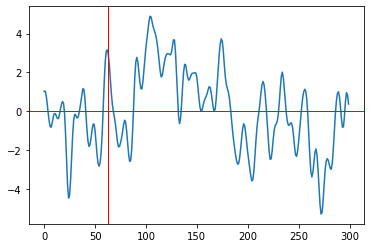

tensor([[0.0982, 0.9018],
        [0.6880, 0.3120],
        [0.6916, 0.3084],
        [0.3402, 0.6598],
        [0.1452, 0.8548],
        [0.4519, 0.5481],
        [0.3815, 0.6185]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  1 predict:  tensor(1, device='cuda:0')
1


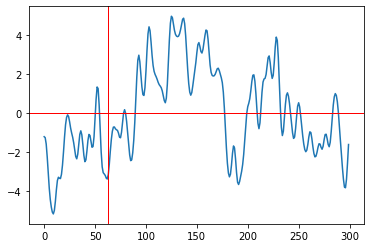

tensor([[0.6832, 0.3168],
        [0.3100, 0.6900],
        [0.9489, 0.0511],
        [0.8478, 0.1522],
        [0.7627, 0.2373],
        [0.6250, 0.3750],
        [0.8489, 0.1511]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  2 predict:  tensor(2, device='cuda:0')
score: 0.6


In [78]:
import numpy as np
from scipy.signal import butter, lfilter, sosfiltfilt
import time
import os, glob
import hdf5storage
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import joblib
import shutil
from datetime import datetime
import socket
from scipy import signal
import matplotlib.pyplot as plt
from keras.models import load_model
import torch
import torch.nn as nn
from torch import optim
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CNN().to(DEVICE)

criterion = nn.BCELoss()
lr = 1e-5
# 더 천천히 모델은 분석 하는것 
optimizer = optim.Adam(model.parameters(), lr=lr)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        conv1 = nn.Conv1d(7, 3, 3, 1, padding=True) # 1, 6 은 임의로 한것
        max_pool = nn.MaxPool1d(4)
        self.bn1 = nn.BatchNorm1d(3)
        fc1 = nn.Linear(3*1*45, 2) # fully connected layer 1번 
        
        self.conv = nn.Sequential(
            conv1,  # N x 7 x 180 -> N x 3 x 180
            self.bn1,
            nn.ReLU(),
            max_pool,  # N x 3 x 180 -> N x 3 x 45

        )
        
        self.fc = nn.Sequential(
            fc1,  # N x 1024 -> N x 32
            nn.Softmax()  # 이건 분류 할때 사용 한거  out 이 1개일땐 다른거 쓰면 
        )

    def forward(self, x):
        x = self.conv(x)
        dim = 1
        for d in x.size()[1:]: #  N x 16 x 1 x 128
            dim = dim * d
            
        x = x.view(-1, dim)
        x = self.fc(x)
        return x
            
Classifier_path = 'D:\\P300_biosemi_55\\Model\\Bio\\'
classifier_list = sorted(glob.glob(Classifier_path + '*.pt'), key=os.path.getmtime, reverse=True)
weight_list = sorted(glob.glob(Classifier_path + 'Weight\\*.pt'), key=os.path.getmtime, reverse=True)
print(classifier_list[0])
model = torch.load(classifier_list[0])
model.load_state_dict(torch.load(weight_list[0]))

# filtering bandwidth
low, high = 0.23, 30

    
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y

def Standardization(Epochs):
    for i in range(Epochs.shape[1]):
        Epochs[:,i,:] = np.subtract(Epochs[:,i,:], np.mean(Epochs[:,i,:]))
        Epochs[:,i,:] = Epochs[:,i,:] / np.std(Epochs[:,i,:])
    
    return Epochs    
    
def Epoching(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
            for i in range(nChannel):
                Epochs[j,i,:] = Epochs[j,i,:] - np.mean(Epochs[j,i,:])
                
#         Epochs = Standardization(Epochs)
        Epochs_Aver = np.mean(Epochs, axis=0)

        return Epochs_Aver
def Balancing_DataSet(Epochs, size):
        Epochs_New = np.zeros((size, Epochs.shape[1], Epochs.shape[2]))
    
        index = np.random.choice(Epochs.shape[0], size = size, replace = False)
    
        Epochs_New = Epochs[index, :, :]
    
        return Epochs_New
def Epoching_v(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
        return [Epochs, Num[0]]    
def plotGraph_v(filename):


        mat = hdf5storage.loadmat(filename)
        channelNames = mat['channelNames']
        eegData = mat['eegData']
        samplingFreq = mat['samplingFreq']
        samplingFreq = samplingFreq[0,0]
        stims = mat['stims']
        channelNum = channelNames.shape
        channelNum = channelNum[1]
        eegData = np.transpose(eegData)
        
        
        #Bandpass Filter
        eegData = butter_bandpass_filter(eegData, 0.23, 30, samplingFreq, order=4)
    
        #Epoching
        epochSampleNum = int(np.floor(0.6 * samplingFreq))
        offset = int(np.floor(0.2 * samplingFreq)) 
        baseline = int(np.floor(0.8 * samplingFreq)) 
        [EpochsT, NumT] = Epoching_v(eegData, stims, 1, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        [EpochsN, NumN] = Epoching_v(eegData, stims, 0, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        
        EpochsN_New = Balancing_DataSet(EpochsN, NumT)
        
        EpochsT = Standardization(EpochsT)
        EpochsN = Standardization(EpochsN_New)
        Target_All=np.mean(EpochsT,axis=0)
        
        return [EpochsT[:,:,:], EpochsN[:,:,:]]  

    
def main():
     #--------------------------------------------------------------    
        root = 'D:\\VR300_20\\S'
        T_all_V= np.zeros((8*210,7,180))
        N_all_V= np.zeros((8*210,7,180))
        count = 0

        for i in np.arange(1,20):
            if i % 2 == 1: 
                if (i==7 or i==13):
                    continue
                if(i<10):
                    count = count + 1
                    root_VR = root + '0' + str(i)+'/Training/mat/'
                    current_list = sorted(glob.glob(root_VR + '*.mat'), key=os.path.getmtime, reverse=True)
                    root_VR = current_list[0]
                else:
                    count = count + 1
                    root_VR = root + str(i)+'/Training/mat/'
                    current_list = sorted(glob.glob(root_VR + '*.mat'), key=os.path.getmtime, reverse=True)
                    root_VR = current_list[0]
                [T_all_V[210*(count-1):210*count,:,:],N_all_V[210*(count-1):210*count,:,:]]=plotGraph_v(root_VR)
    #-------------------------------------------------------
        Target_All=np.mean(T_all_V,axis=0)
        max_I=0
        for k in np.arange(0,7):
            if k == 2:
                a=k+1
                print(a)
                plt.plot(Target_All[k,:])
                plt.axvline(x=np.argmax(Target_All[k,:]), color='r', linewidth=1)
                max_I=np.argmax(Target_All[k,:])
                max_V =max(Target_All[k,:])
                plt.axhline(y=0, color='r', linewidth=1)
                plt.show()
        print(max_I)
        root_path = "D:\\VR300Data\\0315\\Minchul\\"
        Target_All=np.mean(T_all_V,axis=0)
        mat_path = root_path + 'Online\\mat\\'
        current_list = sorted(glob.glob(mat_path + '*.mat'), key=os.path.getmtime)
        score = 0
        wrong_ans = []
        
        target_val = nontarget_val = 0
        
        for mat_file in current_list:
            #print(mat_file)
            ans = mat_file[-5]
            
            mat = hdf5storage.loadmat(mat_file)
            channelNames = mat['channelNames']
            eegData = mat['eegData']
            samplingFreq = mat['samplingFreq']
            samplingFreq = samplingFreq[0,0]
            stims = mat['stims']
            channelNum = channelNames.shape
            channelNum = channelNum[1]
            eegData = np.transpose(eegData)
            buttonNum = 7
            
            #Bandpass Filter
            eegData = butter_bandpass_filter(eegData, low, high, samplingFreq, order=4)

            #Epoching
            epochSampleNum = int(np.floor( 1* samplingFreq))
            offset = int(np.floor(0 * samplingFreq))
            baseline = int(np.floor(1 * samplingFreq))
            
            ####### averaging whole epochs
            Epochs_Aver = np.zeros((buttonNum, channelNum, epochSampleNum))
            
            
            for i in np.arange(0,7):
                Epochs_Aver[i] = Epoching(eegData, stims, (i+1), samplingFreq, channelNum, epochSampleNum, offset, baseline)
            #max_I np.mean(T_all_V,axis=0)
    #*********************************************************
            hz=180

            target_data = Epochs_Aver[int(ans)-1,:,:]
            print(int(ans)-1)
            mat = np.zeros((2, hz))
     
            plt.plot(np.mean(Epochs_Aver[int(ans)-1,:,:],axis=0))
            plt.axvline(x=np.argmax(Target_All[k,:]), color='r', linewidth=1)
            max_I=np.argmax(Target_All[k,:])
            max_V =max(Target_All[k,:])
            plt.axhline(y=0, color='r', linewidth=1)
            plt.show()
            for j in np.arange(0,7):
                mat[0] = Target_All[j,:]
                coef = np.zeros(80)
                q=0
                for b in np.arange(0,80):
                    mat[1] = target_data[j,0*hz+1*b:1*hz+1*(b)]
                    corrcoef = np.corrcoef(mat)
                    coef[q] = corrcoef[0,1]
                    q=q+1
                index = np.argmax(np.abs(coef))
            #실시간 맞춰주기
                start = 0*hz+1*index
                finish = 1*hz+1*(index)
    #*********************************************************             
            b=torch.Tensor(Epochs_Aver[:,:,start:finish].reshape(7,7,180)).to(DEVICE)
            test_output=model(b)
            test_output[:, 1].max(dim=0)
            print(test_output)
            predict= test_output[:, 1].max(dim=0)[1]+1
            
            if int(ans) == int(predict): 
                score = score + 1
            else:
                wrong_ans.append(mat_file[mat_file.rfind('\\')+1:mat_file.rfind('_')])
            print('order: ', ans, 'predict: ', predict)
            
        #print('wrong answer', wrong_ans)
        print('score:', score/(len(wrong_ans)+score))

if __name__ == "__main__":
    main()

In [74]:
import numpy as np
from scipy.signal import butter, lfilter, sosfiltfilt
import time
import os, glob
import hdf5storage
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import joblib
import shutil
from datetime import datetime
import socket
from scipy import signal
import matplotlib.pyplot as plt
from keras.models import load_model
import torch
import torch.nn as nn
from torch import optim
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CNN().to(DEVICE)

criterion = nn.BCELoss()
lr = 1e-5
# 더 천천히 모델은 분석 하는것 
optimizer = optim.Adam(model.parameters(), lr=lr)

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        conv1 = nn.Conv1d(7, 3, 3, 1, padding=True) # 1, 6 은 임의로 한것
        max_pool = nn.MaxPool1d(4)
        self.bn1 = nn.BatchNorm1d(3)
        fc1 = nn.Linear(3*1*45, 2) # fully connected layer 1번 
        
        self.conv = nn.Sequential(
            conv1,  # N x 7 x 180 -> N x 3 x 180
            self.bn1,
            nn.ReLU(),
            max_pool,  # N x 3 x 180 -> N x 3 x 45

        )
        
        self.fc = nn.Sequential(
            fc1,  # N x 1024 -> N x 32
            nn.Softmax()  # 이건 분류 할때 사용 한거  out 이 1개일땐 다른거 쓰면 
        )

    def forward(self, x):
        x = self.conv(x)
        dim = 1
        for d in x.size()[1:]: #  N x 16 x 1 x 128
            dim = dim * d
            
        x = x.view(-1, dim)
        x = self.fc(x)
        return x
            
Classifier_path = 'D:\\P300_biosemi_55\\Model\\Bio\\'
classifier_list = sorted(glob.glob(Classifier_path + '*.pt'), key=os.path.getmtime, reverse=True)
weight_list = sorted(glob.glob(Classifier_path + 'Weight\\*.pt'), key=os.path.getmtime, reverse=True)
print(classifier_list[0])
model = torch.load(classifier_list[0])
model.load_state_dict(torch.load(weight_list[0]))

# filtering bandwidth
low, high = 0.23, 30

    
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y

def Standardization(Epochs):
    for i in range(Epochs.shape[1]):
        Epochs[:,i,:] = np.subtract(Epochs[:,i,:], np.mean(Epochs[:,i,:]))
        Epochs[:,i,:] = Epochs[:,i,:] / np.std(Epochs[:,i,:])
    
    return Epochs    
    
def Epoching(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
            for i in range(nChannel):
                Epochs[j,i,:] = Epochs[j,i,:] - np.mean(Epochs[j,i,:])
                
#         Epochs = Standardization(Epochs)
        Epochs_Aver = np.mean(Epochs, axis=0)

        return Epochs_Aver
def Balancing_DataSet(Epochs, size):
        Epochs_New = np.zeros((size, Epochs.shape[1], Epochs.shape[2]))
    
        index = np.random.choice(Epochs.shape[0], size = size, replace = False)
    
        Epochs_New = Epochs[index, :, :]
    
        return Epochs_New
def Epoching_v(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
        return [Epochs, Num[0]]    
def plotGraph_v(filename):


        mat = hdf5storage.loadmat(filename)
        channelNames = mat['channelNames']
        eegData = mat['eegData']
        samplingFreq = mat['samplingFreq']
        samplingFreq = samplingFreq[0,0]
        stims = mat['stims']
        channelNum = channelNames.shape
        channelNum = channelNum[1]
        eegData = np.transpose(eegData)
        
        
        #Bandpass Filter
        eegData = butter_bandpass_filter(eegData, 0.23, 30, samplingFreq, order=4)
    
        #Epoching
        epochSampleNum = int(np.floor(0.6 * samplingFreq))
        offset = int(np.floor(0.2 * samplingFreq)) 
        baseline = int(np.floor(0.8 * samplingFreq)) 
        [EpochsT, NumT] = Epoching_v(eegData, stims, 1, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        [EpochsN, NumN] = Epoching_v(eegData, stims, 0, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        
        EpochsN_New = Balancing_DataSet(EpochsN, NumT)
        
        EpochsT = Standardization(EpochsT)
        EpochsN = Standardization(EpochsN_New)
        Target_All=np.mean(EpochsT,axis=0)
        
        return [EpochsT[:,:,:], EpochsN[:,:,:]]  

def plotGraph(filename):

        mat = hdf5storage.loadmat(filename)
        channelNames = mat['channelNames']
        eegData = mat['eegData']
        samplingFreq = mat['samplingFreq']
        samplingFreq = samplingFreq[0,0]
        stims = mat['stims']
        channelNum = channelNames.shape
        channelNum = channelNum[1]
        eegData = np.transpose(eegData)

        #Bandpass Filter
        eegData = butter_bandpass_filter(eegData, 0.23, 30, samplingFreq, order=4)
    
        #Epoching
        epochSampleNum = int(np.floor(0.6 * samplingFreq))
        offset = int(np.floor(0.2 * samplingFreq)) 
        baseline = int(np.floor(0.8 * samplingFreq)) 
        [EpochsT, NumT] = Epoching_v(eegData, stims, 1, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        [EpochsN, NumN] = Epoching_v(eegData, stims, 0, samplingFreq, channelNum, epochSampleNum, offset, baseline)
        
        EpochsN_New = Balancing_DataSet(EpochsN, NumT)
        
        EpochsT = Standardization(EpochsT)
        EpochsN = Standardization(EpochsN_New)
        Target_All=np.mean(EpochsT,axis=0)
        
        return EpochsT[:,:,:]
    
def main():
    
        #root = 'D:\\VR300Data\\0129\\Eunjin\\Training\\mat\\Training.mat'
        root =  'D:\\VR300_20\\S02\\Training\\mat\\Training.mat'
        T_all= np.zeros((210,7,180))

        T_all[:,:,:]=plotGraph(root)
        
        Target_All_02=np.mean(T_all,axis=0)
        T_S02_Max = np.argmax(Target_All_02[0,:])
        print(T_S02_Max)
     #--------------------------------------------------------------    
        root = 'D:\\VR300_20\\S'
        T_all_V= np.zeros((8*210,7,180))
        N_all_V= np.zeros((8*210,7,180))
        count = 0

        for i in np.arange(1,20):
            if i % 2 == 1: 
                if (i==7 or i==13):
                    continue
                if(i<10):
                    count = count + 1
                    root_VR = root + '0' + str(i)+'/Training/mat/'
                    current_list = sorted(glob.glob(root_VR + '*.mat'), key=os.path.getmtime, reverse=True)
                    root_VR = current_list[0]
                else:
                    count = count + 1
                    root_VR = root + str(i)+'/Training/mat/'
                    current_list = sorted(glob.glob(root_VR + '*.mat'), key=os.path.getmtime, reverse=True)
                    root_VR = current_list[0]
                [T_all_V[210*(count-1):210*count,:,:],N_all_V[210*(count-1):210*count,:,:]]=plotGraph_v(root_VR)
    #-------------------------------------------------------
        Target_All=np.mean(T_all_V,axis=0)
        max_I=0
        max_I=np.argmax(Target_All[0,:])
        
        Target_All=np.mean(T_all_V,axis=0)
        root_path = "D:\\VR300_20\\S02\\"
        Target_All=np.mean(T_all_V,axis=0)
        mat_path = root_path + 'Online\\mat\\'
        current_list = sorted(glob.glob(mat_path + '*.mat'), key=os.path.getmtime)
        score = 0
        wrong_ans = []
        
        target_val = nontarget_val = 0
        
        for mat_file in current_list:
            #print(mat_file)
            ans = mat_file[-5]
            
            mat = hdf5storage.loadmat(mat_file)
            channelNames = mat['channelNames']
            eegData = mat['eegData']
            samplingFreq = mat['samplingFreq']
            samplingFreq = samplingFreq[0,0]
            stims = mat['stims']
            channelNum = channelNames.shape
            channelNum = channelNum[1]
            eegData = np.transpose(eegData)
            buttonNum = 7
            
            #Bandpass Filter
            eegData = butter_bandpass_filter(eegData, low, high, samplingFreq, order=4)

            #Epoching
            epochSampleNum = int(np.floor( 1* samplingFreq))
            offset = int(np.floor(0 * samplingFreq))
            baseline = int(np.floor(1 * samplingFreq))
            
            ####### averaging whole epochs
            Epochs_Aver = np.zeros((buttonNum, channelNum, epochSampleNum))
            
            
            for i in np.arange(0,7):
                Epochs_Aver[i] = Epoching(eegData, stims, (i+1), samplingFreq, channelNum, epochSampleNum, offset, baseline)
            #max_I np.mean(T_all_V,axis=0)
            start =max_I+ (T_S02_Max - max_I)
            finish= start + 180
            print(start)
            b=torch.Tensor(Epochs_Aver[:,:,start:finish].reshape(7,7,180)).to(DEVICE)
            test_output=model(b)
            test_output[:, 1].max(dim=0)
            print(test_output)
            predict= test_output[:, 1].max(dim=0)[1]+1
            
            if int(ans) == int(predict): 
                score = score + 1
            else:
                wrong_ans.append(mat_file[mat_file.rfind('\\')+1:mat_file.rfind('_')])
            print('order: ', ans, 'predict: ', predict)
            
        #print('wrong answer', wrong_ans)
        print('score:', score/(len(wrong_ans)+score))

if __name__ == "__main__":
    main()

D:\P300_biosemi_55\Model\Bio\ZERO_Bio.pt
55
55
tensor([[0.2628, 0.7372],
        [0.3468, 0.6532],
        [0.7400, 0.2600],
        [0.7083, 0.2917],
        [0.3154, 0.6846],
        [0.0752, 0.9248],
        [0.6647, 0.3353]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  3 predict:  tensor(6, device='cuda:0')
55
tensor([[0.5254, 0.4746],
        [0.1302, 0.8698],
        [0.8112, 0.1888],
        [0.2641, 0.7359],
        [0.3500, 0.6500],
        [0.1225, 0.8775],
        [0.4332, 0.5668]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  1 predict:  tensor(6, device='cuda:0')
55
tensor([[0.0240, 0.9760],
        [0.6988, 0.3012],
        [0.3349, 0.6651],
        [0.2050, 0.7950],
        [0.0865, 0.9135],
        [0.2430, 0.7570],
        [0.4116, 0.5884]], device='cuda:0', grad_fn=<SoftmaxBackward>)
order:  2 predict:  tensor(1, device='cuda:0')
55
tensor([[0.4958, 0.5042],
        [0.1288, 0.8712],
        [0.0569, 0.9431],
        [0.3336, 0.6664],
        [0.1305, 0

In [97]:
import numpy as np
from scipy.signal import butter, lfilter, sosfiltfilt
import time
import os, glob
import hdf5storage
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import joblib
import shutil
from datetime import datetime
import socket
from scipy import signal
import matplotlib.pyplot as plt
from keras.models import load_model
import pandas as pd
from pandas import DataFrame  # 데이터프레임 클래스

import seaborn as sns

Classifier_path = 'D:\\P300_biosemi_55\\Model\\Bio\\'
classifier_list = sorted(glob.glob(Classifier_path + '*.pt'), key=os.path.getmtime, reverse=True)
weight_list = sorted(glob.glob(Classifier_path + 'Weight\\*.pt'), key=os.path.getmtime, reverse=True)
model = torch.load(classifier_list[0])
model.load_state_dict(torch.load(weight_list[0]))

# filtering bandwidth
low, high = 0.23, 30

resampleRate = 100    
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y

def Standardization(Epochs):
    for i in range(Epochs.shape[1]):
        Epochs[:,i,:] = np.subtract(Epochs[:,i,:], np.mean(Epochs[:,i,:]))
        Epochs[:,i,:] = Epochs[:,i,:] / np.std(Epochs[:,i,:])
    
    return Epochs    
def baseline_correction(Epochs):
    for i in range(Epochs.shape[1]):
        for j in range(Epochs.shape[0]):
            Epochs[j,i,:] = np.subtract(Epochs[j,i,:], np.mean(Epochs[j,i,:]))
    
    return Epochs       
def Epoching(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
            for i in range(nChannel):
                Epochs[j,i,:] = Epochs[j,i,:] - np.mean(Epochs[j,i,:])
                
        #Epochs = baseline_correction(Epochs)
        Epochs_Aver = np.mean(Epochs, axis=0)

        return Epochs_Aver
    
def Convert_to_FeatureVector(Epochs, buttonNum, featureNum):
    Features = np.zeros((buttonNum, featureNum))
    for i in range(buttonNum):
        Features[i, :] = np.reshape(Epochs[i, :, :], (1, featureNum))
    return Features

def resampling(Epochs, resampleRate, channelNum):
        resampled_epoch = np.zeros((channelNum, resampleRate))
        for j in range(channelNum):
            resampled_epoch[j,:] = signal.resample(Epochs[j,:], resampleRate)
            
        return resampled_epoch
    
def Convert_to_FeatureVector(Epochs, buttonNum, featureNum):
    Features = np.zeros((buttonNum, featureNum))
    for i in range(buttonNum):
        Features[i, :] = np.reshape(Epochs[i, :, :], (1, featureNum))
    return Features

def main():
    sum=0
    Total_Score=0.0
    score = 0
    total_label =[]
    P300_L= []
    Clas_L = []
    for k in np.arange(1,21):
        if k % 2 == 1:
            root="D:\\VR300_20\\S"
            if(k<10):
                filename = root + '0' + str(k)
            else:
                filename = root + str(k)
            #root_path = "D:\\VR300_20\\S03\\"

            mat_path = filename + '\\Online\\mat\\'
            current_list = sorted(glob.glob(mat_path + '*.mat'), key=os.path.getmtime)
            score = 0
            ans_label= []
            wrong_ans = []

            target_val = nontarget_val = 0
            for mat_file in current_list:
                #print(mat_file)
                ans = mat_file[-5]
                
                mat = hdf5storage.loadmat(mat_file)
                channelNames = mat['channelNames']
                eegData = mat['eegData']
                samplingFreq = mat['samplingFreq']
                samplingFreq = samplingFreq[0,0]
                stims = mat['stims']
                channelNum = channelNames.shape
                channelNum = channelNum[1]
                eegData = np.transpose(eegData)
                buttonNum = 7

                #Bandpass Filter
                eegData = butter_bandpass_filter(eegData, low, high, samplingFreq, order=4)

                #Epoching
                epochSampleNum = int(np.floor(0.6 * samplingFreq))
                offset = int(np.floor(0.2 * samplingFreq))
                baseline = int(np.floor(0.8 * samplingFreq))

                ####### averaging whole epochs
                Epochs_Aver = np.zeros((buttonNum, channelNum, epochSampleNum))
                Epochs_final = np.zeros((buttonNum, channelNum, resampleRate))

                featureNum = channelNum*resampleRate

                for i in range(buttonNum):
                    Epochs_Aver[i] = Epoching(eegData, stims, (i+1), samplingFreq, channelNum, epochSampleNum, offset, baseline)
                    Epochs_final[i] = resampling(Epochs_Aver[i], resampleRate, channelNum)
                #answer=model(Epochs_final)

                #print(Epochs_Aver.shape)
                b=torch.Tensor(Epochs_Aver[:,:,:].reshape(7,7,180)).to(DEVICE)
                test_output=model(b)
                test_output[:, 1].max(dim=0)
                #print(test_output)
                predict= test_output[:, 1].max(dim=0)[1]+1

                if int(ans) == int(predict):
                    score=score+1
                    target_data = np.zeros((1, 7, 180))
                    non_target_data = np.zeros((6, 7, 180))
                    B=0
                    for i in np.arange(0,7):
                        if i==int(predict)-1:
                            target_data=Epochs_Aver[i,:,:].reshape(1,7,180)
                        else:
                            non_target_data[B,:,:]=Epochs_Aver[i,:,:].reshape(1,7,180)
                            B=B+1
                    featureNum = channelNum*epochSampleNum
                    [FeaturesT, FeaturesN] = Convert_to_featureVector(target_data,target_data.shape[0] , non_target_data, non_target_data.shape[0], featureNum)
                    TrainData = np.concatenate((FeaturesT, FeaturesN))
                    TrainLabel = np.concatenate((np.ones((target_data.shape[0],1)).astype(int),np.zeros((non_target_data.shape[0],1)).astype(int))).ravel()
                    Classifier_path = 'D://P300_biosemi_55//Model//LDA//lda.pickle'
                    #Saving LDA classifier
                    lda = LinearDiscriminantAnalysis(solver='lsqr',shrinkage='auto')
                    lda.fit(TrainData, TrainLabel)
                    joblib.dump(lda, Classifier_path, protocol=2)      
                            
                            
                else:
                    wrong_ans.append(mat_file[mat_file.rfind('\\')+1:mat_file.rfind('_')])
                    
                #print('order: ', ans, 'predict: ', predict)

            print(k,'score:', score/(len(wrong_ans)+score))
        Classifier_path_B =  'D://P300_biosemi_55//Model//LDA//'
        classifier_list_B = sorted(glob.glob(Classifier_path_B + '*.pickle'), key=os.path.getmtime, reverse=True)
        Classifier_real = classifier_list_B[0]
        lda = LinearDiscriminantAnalysis(solver='lsqr',shrinkage='auto')
        lda = joblib.load(Classifier_real)
        score=0
    for k in np.arange(1,21):
        if k % 2 == 0:
            root="D:\\VR300_20\\S"
            if(k<10):
                filename = root + '0' + str(k)
            else:
                filename = root + str(k)
            #root_path = "D:\\VR300_20\\S03\\"

            mat_path = filename + '\\Online\\mat\\'
            current_list = sorted(glob.glob(mat_path + '*.mat'), key=os.path.getmtime)
            score = 0
            ans_label= []
            wrong_ans = []

            target_val = nontarget_val = 0
            for mat_file in current_list:
                #print(mat_file)
                ans = mat_file[-5]
                
                mat = hdf5storage.loadmat(mat_file)
                channelNames = mat['channelNames']
                eegData = mat['eegData']
                samplingFreq = mat['samplingFreq']
                samplingFreq = samplingFreq[0,0]
                stims = mat['stims']
                channelNum = channelNames.shape
                channelNum = channelNum[1]
                eegData = np.transpose(eegData)
                buttonNum = 7

                #Bandpass Filter
                eegData = butter_bandpass_filter(eegData, low, high, samplingFreq, order=4)

                #Epoching
                epochSampleNum = int(np.floor(0.6 * samplingFreq))
                offset = int(np.floor(0.2 * samplingFreq))
                baseline = int(np.floor(0.8 * samplingFreq))

                ####### averaging whole epochs
                Epochs_Aver = np.zeros((buttonNum, channelNum, epochSampleNum))
                Epochs_final = np.zeros((buttonNum, channelNum, resampleRate))

                featureNum = channelNum*resampleRate

                for i in range(buttonNum):
                    Epochs_Aver[i] = Epoching(eegData, stims, (i+1), samplingFreq, channelNum, epochSampleNum, offset, baseline)
                    Epochs_final[i] = resampling(Epochs_Aver[i], resampleRate, channelNum)
                #answer=model(Epochs_final)
                featureNum = channelNum*epochSampleNum
                Features = Convert_to_FeatureVector(Epochs_Aver, 7, featureNum)

                Answers = lda.decision_function(Features)
                predict = np.argmax(Answers) + 1

                if int(ans) == int(predict): 
                    score = score + 1
                else:
                    wrong_ans.append(mat_file[mat_file.rfind('\\')+1:mat_file.rfind('_')])
                #print('order: ', ans, 'predict: ', predict)

            print(k,'score:', score/(len(wrong_ans)+score))

if __name__ == "__main__":
    main()

1 score: 0.7
3 score: 0.45
5 score: 0.4
7 score: 0.3
9 score: 0.5333333333333333
11 score: 0.7
13 score: 0.4666666666666667
15 score: 0.6
17 score: 0.9
19 score: 0.9666666666666667
2 score: 0.26666666666666666
4 score: 0.5666666666666667
6 score: 0.5666666666666667
8 score: 1.0
10 score: 0.5666666666666667
12 score: 0.23333333333333334
14 score: 0.5333333333333333
16 score: 0.4666666666666667
18 score: 0.26666666666666666
20 score: 0.9333333333333333


In [126]:
import numpy as np
from scipy.signal import butter, lfilter, sosfiltfilt
import time
import os, glob
import hdf5storage
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import joblib
import shutil
from datetime import datetime
import socket
from scipy import signal
import matplotlib.pyplot as plt
from keras.models import load_model
import pandas as pd
from pandas import DataFrame  # 데이터프레임 클래스

import seaborn as sns

Classifier_path = 'D:\\P300_biosemi_55\\Model\\Bio\\'
classifier_list = sorted(glob.glob(Classifier_path + '*.pt'), key=os.path.getmtime, reverse=True)
weight_list = sorted(glob.glob(Classifier_path + 'Weight\\*.pt'), key=os.path.getmtime, reverse=True)
model = torch.load(classifier_list[0])
model.load_state_dict(torch.load(weight_list[0]))

# filtering bandwidth
low, high = 0.23, 30

resampleRate = 100    
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y

def Standardization(Epochs):
    for i in range(Epochs.shape[1]):
        Epochs[:,i,:] = np.subtract(Epochs[:,i,:], np.mean(Epochs[:,i,:]))
        Epochs[:,i,:] = Epochs[:,i,:] / np.std(Epochs[:,i,:])
    
    return Epochs    
def baseline_correction(Epochs):
    for i in range(Epochs.shape[1]):
        for j in range(Epochs.shape[0]):
            Epochs[j,i,:] = np.subtract(Epochs[j,i,:], np.mean(Epochs[j,i,:]))
    
    return Epochs       
def Epoching(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
            for i in range(nChannel):
                Epochs[j,i,:] = Epochs[j,i,:] - np.mean(Epochs[j,i,:])
                
        #Epochs = baseline_correction(Epochs)
        Epochs_Aver = np.mean(Epochs, axis=0)

        return Epochs_Aver
    
def Convert_to_FeatureVector(Epochs, buttonNum, featureNum):
    Features = np.zeros((buttonNum, featureNum))
    for i in range(buttonNum):
        Features[i, :] = np.reshape(Epochs[i, :, :], (1, featureNum))
    return Features

def resampling(Epochs, resampleRate, channelNum):
        resampled_epoch = np.zeros((channelNum, resampleRate))
        for j in range(channelNum):
            resampled_epoch[j,:] = signal.resample(Epochs[j,:], resampleRate)
            
        return resampled_epoch
    
def Convert_to_FeatureVector(Epochs, buttonNum, featureNum):
    Features = np.zeros((buttonNum, featureNum))
    for i in range(buttonNum):
        Features[i, :] = np.reshape(Epochs[i, :, :], (1, featureNum))
    return Features

def main():
    sum=0
    Total_Score=0.0
    score = 0
    total_label =[]
    P300_L= []
    Clas_L = []
    for k in np.arange(1,21):
            root="D:\\VR300_20\\S"
            if(k<10):
                filename = root + '0' + str(k)
            else:
                filename = root + str(k)
            #root_path = "D:\\VR300_20\\S03\\"

            mat_path = filename + '\\Online\\mat\\'
            current_list = sorted(glob.glob(mat_path + '*.mat'), key=os.path.getmtime)
            score = 0
            ans_label= []
            wrong_ans = []

            target_val = nontarget_val = 0
            for mat_file in current_list:
                #print(mat_file)
                ans = mat_file[-5]
                
                mat = hdf5storage.loadmat(mat_file)
                channelNames = mat['channelNames']
                eegData = mat['eegData']
                samplingFreq = mat['samplingFreq']
                samplingFreq = samplingFreq[0,0]
                stims = mat['stims']
                channelNum = channelNames.shape
                channelNum = channelNum[1]
                eegData = np.transpose(eegData)
                buttonNum = 7

                #Bandpass Filter
                eegData = butter_bandpass_filter(eegData, low, high, samplingFreq, order=4)

                #Epoching
                epochSampleNum = int(np.floor(0.6 * samplingFreq))
                offset = int(np.floor(0.2 * samplingFreq))
                baseline = int(np.floor(0.8 * samplingFreq))

                ####### averaging whole epochs
                Epochs_Aver = np.zeros((buttonNum, channelNum, epochSampleNum))
                Epochs_final = np.zeros((buttonNum, channelNum, resampleRate))

                featureNum = channelNum*resampleRate

                for i in range(buttonNum):
                    Epochs_Aver[i] = Epoching(eegData, stims, (i+1), samplingFreq, channelNum, epochSampleNum, offset, baseline)
                    Epochs_final[i] = resampling(Epochs_Aver[i], resampleRate, channelNum)
                #answer=model(Epochs_final)

                #print(Epochs_Aver.shape)
                b=torch.Tensor(Epochs_Aver[:,:,:].reshape(7,7,180)).to(DEVICE)
                test_output=model(b)
                test_output[:, 1].max(dim=0)
                #print(test_output)
                predict_t= test_output[:, 1].max(dim=0)[1]+1
                
                
    #######여기 라벨을 붙여주는곳
                target_data = np.zeros((1, 7, 180))
                non_target_data = np.zeros((6, 7, 180))
                B=0
                for i in np.arange(0,7):
                    if i==int(predict_t)-1:
                        target_data=Epochs_Aver[i,:,:].reshape(1,7,180)
                    else:
                        non_target_data[B,:,:]=Epochs_Aver[i,:,:].reshape(1,7,180)
                        B=B+1
    ############################### 
                featureNum = channelNum*epochSampleNum
                [FeaturesT, FeaturesN] = Convert_to_featureVector(target_data,target_data.shape[0] , non_target_data, non_target_data.shape[0], featureNum)
                TrainData = np.concatenate((FeaturesT, FeaturesN))
                TrainLabel = np.concatenate((np.ones((target_data.shape[0],1)).astype(int),np.zeros((non_target_data.shape[0],1)).astype(int))).ravel()
                Classifier_path = 'D://P300_biosemi_55//Model//LDA//lda.pickle'
                #Saving LDA classifier
                lda = LinearDiscriminantAnalysis(solver='lsqr',shrinkage='auto')
                lda.fit(TrainData, TrainLabel)
                joblib.dump(lda, Classifier_path, protocol=2)

                Classifier_path_B =  'D://P300_biosemi_55//Model//LDA//'
                classifier_list_B = sorted(glob.glob(Classifier_path_B + '*.pickle'), key=os.path.getmtime, reverse=True)
                Classifier_real = classifier_list_B[0]
                lda = LinearDiscriminantAnalysis(solver='lsqr',shrinkage='auto')
                lda = joblib.load(Classifier_real)

                featureNum = channelNum*epochSampleNum
                Features = Convert_to_FeatureVector(Epochs_Aver, 7, featureNum)

                Answers = lda.decision_function(Features)
                predict = np.argmax(Answers) + 1

                if int(ans) == int(predict): 
                    score = score + 1
                else:
                    wrong_ans.append(mat_file[mat_file.rfind('\\')+1:mat_file.rfind('_')])
                print('order: ', ans, 'predict: ', predict)

            #print('wrong answer', wrong_ans)
            print(k,'score:', score/(len(wrong_ans)+score))
                

if __name__ == "__main__":
    main()

order:  7 predict:  7
order:  3 predict:  3
order:  4 predict:  4
order:  6 predict:  6
order:  2 predict:  2
order:  2 predict:  2
order:  1 predict:  1
order:  1 predict:  1
order:  5 predict:  5
order:  5 predict:  7
order:  3 predict:  3
order:  7 predict:  7
order:  3 predict:  3
order:  5 predict:  5
order:  2 predict:  2
order:  2 predict:  2
order:  1 predict:  1
order:  1 predict:  1
order:  5 predict:  5
order:  5 predict:  5
order:  3 predict:  3
order:  1 predict:  1
order:  2 predict:  2
order:  3 predict:  3
order:  7 predict:  7
order:  4 predict:  3
order:  6 predict:  5
order:  3 predict:  3
order:  3 predict:  5
order:  3 predict:  1
order:  3 predict:  5
order:  1 predict:  1
order:  2 predict:  1
order:  2 predict:  7
order:  2 predict:  1
order:  2 predict:  1
order:  2 predict:  1
order:  2 predict:  2
order:  3 predict:  1


KeyboardInterrupt: 

In [116]:
import numpy as np
from scipy.signal import butter, lfilter, sosfiltfilt
import time
import os, glob
import hdf5storage
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import joblib
import shutil
from datetime import datetime
import socket
from scipy import signal
import matplotlib.pyplot as plt
from keras.models import load_model
import pandas as pd
from pandas import DataFrame  # 데이터프레임 클래스

import seaborn as sns

Classifier_path = 'D:\\P300_biosemi_55\\Model\\Bio\\'
classifier_list = sorted(glob.glob(Classifier_path + '*.pt'), key=os.path.getmtime, reverse=True)
weight_list = sorted(glob.glob(Classifier_path + 'Weight\\*.pt'), key=os.path.getmtime, reverse=True)
model = torch.load(classifier_list[0])
model.load_state_dict(torch.load(weight_list[0]))

# filtering bandwidth
low, high = 0.23, 30

resampleRate = 100    
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y

def Standardization(Epochs):
    for i in range(Epochs.shape[1]):
        Epochs[:,i,:] = np.subtract(Epochs[:,i,:], np.mean(Epochs[:,i,:]))
        Epochs[:,i,:] = Epochs[:,i,:] / np.std(Epochs[:,i,:])
    
    return Epochs    
def baseline_correction(Epochs):
    for i in range(Epochs.shape[1]):
        for j in range(Epochs.shape[0]):
            Epochs[j,i,:] = np.subtract(Epochs[j,i,:], np.mean(Epochs[j,i,:]))
    
    return Epochs       
def Epoching(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
            for i in range(nChannel):
                Epochs[j,i,:] = Epochs[j,i,:] - np.mean(Epochs[j,i,:])
                
        #Epochs = baseline_correction(Epochs)
        Epochs_Aver = np.mean(Epochs, axis=0)

        return Epochs_Aver
    
def Convert_to_FeatureVector(Epochs, buttonNum, featureNum):
    Features = np.zeros((buttonNum, featureNum))
    for i in range(buttonNum):
        Features[i, :] = np.reshape(Epochs[i, :, :], (1, featureNum))
    return Features

def resampling(Epochs, resampleRate, channelNum):
        resampled_epoch = np.zeros((channelNum, resampleRate))
        for j in range(channelNum):
            resampled_epoch[j,:] = signal.resample(Epochs[j,:], resampleRate)
            
        return resampled_epoch
    
def Convert_to_FeatureVector(Epochs, buttonNum, featureNum):
    Features = np.zeros((buttonNum, featureNum))
    for i in range(buttonNum):
        Features[i, :] = np.reshape(Epochs[i, :, :], (1, featureNum))
    return Features

def main():
     #--------------------------------------------------------------    
    root = 'D:\\VR300_20\\S'
    T_all_V= np.zeros((8*210,7,180))
    N_all_V= np.zeros((8*210,7,180))
    count = 0

    for i in np.arange(1,21):
        if i % 2 == 1: 
            if (i==7 or i==13):
                continue
            if(i<10):
                count = count + 1
                root_VR = root + '0' + str(i)+'/Training/mat/'
                current_list = sorted(glob.glob(root_VR + '*.mat'), key=os.path.getmtime, reverse=True)
                root_VR = current_list[0]
            else:
                count = count + 1
                root_VR = root + str(i)+'/Training/mat/'
                current_list = sorted(glob.glob(root_VR + '*.mat'), key=os.path.getmtime, reverse=True)
                root_VR = current_list[0]
            [T_all_V[210*(count-1):210*count,:,:],N_all_V[210*(count-1):210*count,:,:]]=plotGraph_v(root_VR)
    #-------------------------------------------------------
    Target_All=np.mean(T_all_V,axis=0)
    sum=0
    Total_Score=0.0
    score = 0
    total_label =[]
    P300_L= []
    Clas_L = []
    for k in np.arange(1,21):
            root="D:\\VR300_20\\S"
            if(k<10):
                filename = root + '0' + str(k)
            else:
                filename = root + str(k)
            #root_path = "D:\\VR300_20\\S03\\"

            mat_path = filename + '\\Online\\mat\\'
            current_list = sorted(glob.glob(mat_path + '*.mat'), key=os.path.getmtime)
            score = 0
            ans_label= []
            wrong_ans = []

            target_val = nontarget_val = 0
            for mat_file in current_list:
                #print(mat_file)
                ans = mat_file[-5]
                
                mat = hdf5storage.loadmat(mat_file)
                channelNames = mat['channelNames']
                eegData = mat['eegData']
                samplingFreq = mat['samplingFreq']
                samplingFreq = samplingFreq[0,0]
                stims = mat['stims']
                channelNum = channelNames.shape
                channelNum = channelNum[1]
                eegData = np.transpose(eegData)
                buttonNum = 7

                #Bandpass Filter
                eegData = butter_bandpass_filter(eegData, low, high, samplingFreq, order=4)

                #Epoching
                epochSampleNum = int(np.floor(1 * samplingFreq))
                offset = int(np.floor(0 * samplingFreq))
                baseline = int(np.floor(1 * samplingFreq))

                ####### averaging whole epochs
                Epochs_Aver = np.zeros((buttonNum, channelNum, epochSampleNum))
                Epochs_final = np.zeros((buttonNum, channelNum, resampleRate))

                featureNum = channelNum*resampleRate

                for i in range(buttonNum):
                    Epochs_Aver[i] = Epoching(eegData, stims, (i+1), samplingFreq, channelNum, epochSampleNum, offset, baseline)
                    Epochs_final[i] = resampling(Epochs_Aver[i], resampleRate, channelNum)
                #answer=model(Epochs_final)
        #*********************************************************
                hz=180

                target_data = Epochs_Aver[int(ans)-1,:,:]
                mat = np.zeros((2, hz))
                for j in np.arange(0,7):
                    mat[0] = Target_All[j,:]
                    coef = np.zeros(70)
                    q=0
                    for b in np.arange(0,70):
                        mat[1] = target_data[j,0*hz+1*b:1*hz+1*(b)]
                        corrcoef = np.corrcoef(mat)
                        coef[q] = corrcoef[0,1]
                        q=q+1
                    index = np.argmax(np.abs(coef))
                #실시간 맞춰주기
                    start = 0*hz+1*index
                    finish = 1*hz+1*(index)
        #*********************************************************   
                #print(Epochs_Aver.shape)
                b=torch.Tensor(Epochs_Aver[:,:,start:finish].reshape(7,7,180)).to(DEVICE)
                test_output=model(b)
                test_output[:, 1].max(dim=0)
                #print(test_output)
                predict_t= test_output[:, 1].max(dim=0)[1]+1
                
                
    #######여기 라벨을 붙여주는곳
                target_data = np.zeros((1, 7, 180))
                non_target_data = np.zeros((6, 7, 180))
                B=0
                for i in np.arange(0,7):
                    if i==int(predict_t)-1:
                        target_data=Epochs_Aver[i,:,start:finish].reshape(1,7,180)
                    else:
                        non_target_data[B,:,:]=Epochs_Aver[i,:,start:finish].reshape(1,7,180)
                        B=B+1
    ############################### 
                epochSampleNum=180
                featureNum = channelNum*epochSampleNum
                [FeaturesT, FeaturesN] = Convert_to_featureVector(target_data,target_data.shape[0] , non_target_data, non_target_data.shape[0], featureNum)
                TrainData = np.concatenate((FeaturesT, FeaturesN))
                TrainLabel = np.concatenate((np.ones((target_data.shape[0],1)).astype(int),np.zeros((non_target_data.shape[0],1)).astype(int))).ravel()
                Classifier_path = 'D://P300_biosemi_55//Model//LDA//lda.pickle'
                #Saving LDA classifier
                lda = LinearDiscriminantAnalysis(solver='lsqr',shrinkage='auto')
                lda.fit(TrainData, TrainLabel)
                joblib.dump(lda, Classifier_path, protocol=2)

                Classifier_path_B =  'D://P300_biosemi_55//Model//LDA//'
                classifier_list_B = sorted(glob.glob(Classifier_path_B + '*.pickle'), key=os.path.getmtime, reverse=True)
                Classifier_real = classifier_list_B[0]
                lda = LinearDiscriminantAnalysis(solver='lsqr',shrinkage='auto')
                lda = joblib.load(Classifier_real)

                featureNum = channelNum*epochSampleNum
                Features = Convert_to_FeatureVector(Epochs_Aver[:,:,start:finish], 7, featureNum)

                Answers = lda.decision_function(Features)
                predict = np.argmax(Answers) + 1

                if int(ans) == int(predict): 
                    score = score + 1
                else:
                    wrong_ans.append(mat_file[mat_file.rfind('\\')+1:mat_file.rfind('_')])
                #print('order: ', ans, 'predict: ', predict)

            #print('wrong answer', wrong_ans)
            print(k,'score:', score/(len(wrong_ans)+score))
                

if __name__ == "__main__":
    main()

1 score: 0.6
2 score: 0.3333333333333333
3 score: 0.45
4 score: 0.43333333333333335
5 score: 0.5
6 score: 0.5
7 score: 0.13333333333333333
8 score: 0.8333333333333334
9 score: 0.6
10 score: 0.7
11 score: 0.8333333333333334
12 score: 0.16666666666666666
13 score: 0.3
14 score: 0.5
15 score: 0.5666666666666667
16 score: 0.3333333333333333
17 score: 0.7333333333333333
18 score: 0.5666666666666667
19 score: 0.9666666666666667
20 score: 0.6333333333333333


In [140]:
import numpy as np
from scipy.signal import butter, lfilter, sosfiltfilt
import time
import os, glob
import hdf5storage
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import joblib
import shutil
from datetime import datetime
import socket
from scipy import signal
import matplotlib.pyplot as plt
from keras.models import load_model
import pandas as pd
from pandas import DataFrame  # 데이터프레임 클래스

import seaborn as sns

Classifier_path = 'D:\\P300_biosemi_55\\Model\\Bio\\'
classifier_list = sorted(glob.glob(Classifier_path + '*.pt'), key=os.path.getmtime, reverse=True)
weight_list = sorted(glob.glob(Classifier_path + 'Weight\\*.pt'), key=os.path.getmtime, reverse=True)
model = torch.load(classifier_list[0])
model.load_state_dict(torch.load(weight_list[0]))

# filtering bandwidth
low, high = 0.23, 30

resampleRate = 100    
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y

def Standardization(Epochs):
    for i in range(Epochs.shape[1]):
        Epochs[:,i,:] = np.subtract(Epochs[:,i,:], np.mean(Epochs[:,i,:]))
        Epochs[:,i,:] = Epochs[:,i,:] / np.std(Epochs[:,i,:])
    
    return Epochs    
def baseline_correction(Epochs):
    for i in range(Epochs.shape[1]):
        for j in range(Epochs.shape[0]):
            Epochs[j,i,:] = np.subtract(Epochs[j,i,:], np.mean(Epochs[j,i,:]))
    
    return Epochs       
def Epoching(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
            for i in range(nChannel):
                Epochs[j,i,:] = Epochs[j,i,:] - np.mean(Epochs[j,i,:])
                
        #Epochs = baseline_correction(Epochs)
        Epochs_Aver = np.mean(Epochs, axis=0)

        return Epochs_Aver
    
def Convert_to_FeatureVector(Epochs, buttonNum, featureNum):
    Features = np.zeros((buttonNum, featureNum))
    for i in range(buttonNum):
        Features[i, :] = np.reshape(Epochs[i, :, :], (1, featureNum))
    return Features

def resampling(Epochs, resampleRate, channelNum):
        resampled_epoch = np.zeros((channelNum, resampleRate))
        for j in range(channelNum):
            resampled_epoch[j,:] = signal.resample(Epochs[j,:], resampleRate)
            
        return resampled_epoch
    
def Convert_to_FeatureVector(Epochs, buttonNum, featureNum):
    Features = np.zeros((buttonNum, featureNum))
    for i in range(buttonNum):
        Features[i, :] = np.reshape(Epochs[i, :, :], (1, featureNum))
    return Features

def main():
    sum=0
    Total_Score=0.0
    score = 0
    total_label =[]
    P300_L= []
    Clas_L = []
    count=0
    target_data_temp = np.zeros((1*260, 7, 180))
    non_target_data_temp = np.zeros((1*260, 7, 180))
    for k in np.arange(1,21):
        if (k==7 or k==13):
            continue
        elif k % 2==1:
            root="D:\\VR300_20\\S"
            if(k<10):
                filename = root + '0' + str(k)
            else:
                filename = root + str(k)
            #root_path = "D:\\VR300_20\\S03\\"

            mat_path = filename + '\\Online\\mat\\'
            current_list = sorted(glob.glob(mat_path + '*.mat'), key=os.path.getmtime)
            score = 0
            ans_label= []
            wrong_ans = []

            target_val = nontarget_val = 0
            for mat_file in current_list:
                #print(mat_file)
                ans = mat_file[-5]
                
                mat = hdf5storage.loadmat(mat_file)
                channelNames = mat['channelNames']
                eegData = mat['eegData']
                samplingFreq = mat['samplingFreq']
                samplingFreq = samplingFreq[0,0]
                stims = mat['stims']
                channelNum = channelNames.shape
                channelNum = channelNum[1]
                eegData = np.transpose(eegData)
                buttonNum = 7

                #Bandpass Filter
                eegData = butter_bandpass_filter(eegData, low, high, samplingFreq, order=4)

                #Epoching
                epochSampleNum = int(np.floor(0.6 * samplingFreq))
                offset = int(np.floor(0.2 * samplingFreq))
                baseline = int(np.floor(0.8 * samplingFreq))

                ####### averaging whole epochs
                Epochs_Aver = np.zeros((buttonNum, channelNum, epochSampleNum))
                Epochs_final = np.zeros((buttonNum, channelNum, resampleRate))

                featureNum = channelNum*resampleRate

                for i in range(buttonNum):
                    Epochs_Aver[i] = Epoching(eegData, stims, (i+1), samplingFreq, channelNum, epochSampleNum, offset, baseline)
                    Epochs_final[i] = resampling(Epochs_Aver[i], resampleRate, channelNum)
                #answer=model(Epochs_final)

                #print(Epochs_Aver.shape)
                b=torch.Tensor(Epochs_Aver[:,:,:].reshape(7,7,180)).to(DEVICE)
                test_output=model(b)
                test_output[:, 1].max(dim=0)
                #print(test_output)
                predict_t= test_output[:, 1].max(dim=0)[1]+1
                
                
#######여기 라벨을 붙여주는곳
                
                target_data = np.zeros((1, 7, 180))
                non_target_data = np.zeros((6, 7, 180))
                B=0
                for i in np.arange(0,7):
                    if i==int(predict_t)-1:
                        target_data=Epochs_Aver[i,:,:]
                    else:
                        non_target_data[B,:,:]=Epochs_Aver[i,:,:]
                        B=B+1
                target_data_temp[count,:,:]=target_data
                non_target_data_temp[count,:,:]=non_target_data.mean(axis=0)
                count=count+1
############################### 
                
        featureNum = channelNum*epochSampleNum
        [FeaturesT, FeaturesN] = Convert_to_featureVector(target_data_temp,target_data_temp.shape[0] , non_target_data_temp, non_target_data_temp.shape[0], featureNum)
        TrainData = np.concatenate((FeaturesT, FeaturesN))
        TrainLabel = np.concatenate((np.ones((target_data_temp.shape[0],1)).astype(int),np.zeros((non_target_data_temp.shape[0],1)).astype(int))).ravel()
        Classifier_path = 'D://P300_biosemi_55//Model//LDA//lda.pickle'
        #Saving LDA classifier
        lda = LinearDiscriminantAnalysis(solver='lsqr',shrinkage='auto')
        lda.fit(TrainData, TrainLabel)
        joblib.dump(lda, Classifier_path, protocol=2)

        Classifier_path_B =  'D://P300_biosemi_55//Model//LDA//'
        classifier_list_B = sorted(glob.glob(Classifier_path_B + '*.pickle'), key=os.path.getmtime, reverse=True)
        Classifier_real = classifier_list_B[0]
        lda = LinearDiscriminantAnalysis(solver='lsqr',shrinkage='auto')
        lda = joblib.load(Classifier_real)
    for k in np.arange(1,21):
        if k % 2==0:
            root="D:\\VR300_20\\S"
            if(k<10):
                filename = root + '0' + str(k)
            else:
                filename = root + str(k)
            #root_path = "D:\\VR300_20\\S03\\"

            mat_path = filename + '\\Online\\mat\\'
            current_list = sorted(glob.glob(mat_path + '*.mat'), key=os.path.getmtime)
            score = 0
            ans_label= []
            wrong_ans = []

            target_val = nontarget_val = 0
            for mat_file in current_list:
                #print(mat_file)
                ans = mat_file[-5]
                
                mat = hdf5storage.loadmat(mat_file)
                channelNames = mat['channelNames']
                eegData = mat['eegData']
                samplingFreq = mat['samplingFreq']
                samplingFreq = samplingFreq[0,0]
                stims = mat['stims']
                channelNum = channelNames.shape
                channelNum = channelNum[1]
                eegData = np.transpose(eegData)
                buttonNum = 7

                #Bandpass Filter
                eegData = butter_bandpass_filter(eegData, low, high, samplingFreq, order=4)

                #Epoching
                epochSampleNum = int(np.floor(0.6 * samplingFreq))
                offset = int(np.floor(0.2 * samplingFreq))
                baseline = int(np.floor(0.8 * samplingFreq))

                ####### averaging whole epochs
                Epochs_Aver = np.zeros((buttonNum, channelNum, epochSampleNum))
                Epochs_final = np.zeros((buttonNum, channelNum, resampleRate))

                featureNum = channelNum*resampleRate

                for i in range(buttonNum):
                    Epochs_Aver[i] = Epoching(eegData, stims, (i+1), samplingFreq, channelNum, epochSampleNum, offset, baseline)
                    Epochs_final[i] = resampling(Epochs_Aver[i], resampleRate, channelNum)
                featureNum = channelNum*epochSampleNum
                Features = Convert_to_FeatureVector(Epochs_Aver, 7, featureNum)

                Answers = lda.decision_function(Features)
                predict = np.argmax(Answers) + 1

                if int(ans) == int(predict): 
                    score = score + 1
                else:
                    wrong_ans.append(mat_file[mat_file.rfind('\\')+1:mat_file.rfind('_')])
                #print('order: ', ans, 'predict: ', predict)

            #print('wrong answer', wrong_ans)
            print(k,'score:', score/(len(wrong_ans)+score))
                
    
if __name__ == "__main__":
    main()

2 score: 0.23333333333333334
4 score: 0.7333333333333333
6 score: 0.6666666666666666
8 score: 0.9666666666666667
10 score: 0.5333333333333333
12 score: 0.16666666666666666
14 score: 0.3
16 score: 0.6
18 score: 0.43333333333333335
20 score: 0.5666666666666667


In [ ]:
import numpy as np
from scipy.signal import butter, lfilter, sosfiltfilt
import time
import os, glob
import hdf5storage
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import joblib
import shutil
from datetime import datetime
import socket
from scipy import signal
import matplotlib.pyplot as plt
from keras.models import load_model
import pandas as pd
from pandas import DataFrame  # 데이터프레임 클래스

import seaborn as sns

Classifier_path = 'D:\\P300_biosemi_55\\Model\\Bio\\'
classifier_list = sorted(glob.glob(Classifier_path + '*.pt'), key=os.path.getmtime, reverse=True)
weight_list = sorted(glob.glob(Classifier_path + 'Weight\\*.pt'), key=os.path.getmtime, reverse=True)
model = torch.load(classifier_list[0])
model.load_state_dict(torch.load(weight_list[0]))

# filtering bandwidth
low, high = 0.23, 30

resampleRate = 100    
def butter_bandpass(lowcut, highcut, fs, order=5):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        y = lfilter(b, a, data)
        return y

def Standardization(Epochs):
    for i in range(Epochs.shape[1]):
        Epochs[:,i,:] = np.subtract(Epochs[:,i,:], np.mean(Epochs[:,i,:]))
        Epochs[:,i,:] = Epochs[:,i,:] / np.std(Epochs[:,i,:])
    
    return Epochs    
def baseline_correction(Epochs):
    for i in range(Epochs.shape[1]):
        for j in range(Epochs.shape[0]):
            Epochs[j,i,:] = np.subtract(Epochs[j,i,:], np.mean(Epochs[j,i,:]))
    
    return Epochs       
def Epoching(eegData, stims, code, samplingRate, nChannel, epochSampleNum, epochOffset,baseline):
        Time = stims[np.where(stims[:,1] == code),0][0]
        Time = np.floor(np.multiply(Time,samplingRate)).astype(int)
        Time_after = np.add(Time,epochOffset).astype(int)
        Time_base = np.add(Time,baseline).astype(int)
        Num = Time.shape
        Epochs = np.zeros((Num[0], nChannel, epochSampleNum))
        for j in range(Num[0]):
            Epochs[j, :, :] = eegData[:, Time_after[j]:Time_after[j] + epochSampleNum]
            
            for i in range(nChannel):
                Epochs[j,i,:] = Epochs[j,i,:] - np.mean(Epochs[j,i,:])
                
        #Epochs = baseline_correction(Epochs)
        Epochs_Aver = np.mean(Epochs, axis=0)

        return Epochs_Aver
    
def Convert_to_FeatureVector(Epochs, buttonNum, featureNum):
    Features = np.zeros((buttonNum, featureNum))
    for i in range(buttonNum):
        Features[i, :] = np.reshape(Epochs[i, :, :], (1, featureNum))
    return Features

def resampling(Epochs, resampleRate, channelNum):
        resampled_epoch = np.zeros((channelNum, resampleRate))
        for j in range(channelNum):
            resampled_epoch[j,:] = signal.resample(Epochs[j,:], resampleRate)
            
        return resampled_epoch
    
def Convert_to_FeatureVector(Epochs, buttonNum, featureNum):
    Features = np.zeros((buttonNum, featureNum))
    for i in range(buttonNum):
        Features[i, :] = np.reshape(Epochs[i, :, :], (1, featureNum))
    return Features

def main():
    sum=0
    Total_Score=0.0
    score = 0
    total_label =[]
    P300_L= []
    Clas_L = []
    count=0
    target_data_temp = np.zeros((1*320, 7, 180))
    non_target_data_temp = np.zeros((1*320, 7, 180))
    for k in np.arange(1,21):
        if k % 2==1:
            root="D:\\VR300_20\\S"
            if(k<10):
                filename = root + '0' + str(k)
            else:
                filename = root + str(k)
            #root_path = "D:\\VR300_20\\S03\\"

            mat_path = filename + '\\Online\\mat\\'
            current_list = sorted(glob.glob(mat_path + '*.mat'), key=os.path.getmtime)
            score = 0
            ans_label= []
            wrong_ans = []

            target_val = nontarget_val = 0
            for mat_file in current_list:
                #print(mat_file)
                ans = mat_file[-5]
                
                mat = hdf5storage.loadmat(mat_file)
                channelNames = mat['channelNames']
                eegData = mat['eegData']
                samplingFreq = mat['samplingFreq']
                samplingFreq = samplingFreq[0,0]
                stims = mat['stims']
                channelNum = channelNames.shape
                channelNum = channelNum[1]
                eegData = np.transpose(eegData)
                buttonNum = 7

                #Bandpass Filter
                eegData = butter_bandpass_filter(eegData, low, high, samplingFreq, order=4)

                #Epoching
                epochSampleNum = int(np.floor(0.6 * samplingFreq))
                offset = int(np.floor(0.2 * samplingFreq))
                baseline = int(np.floor(0.8 * samplingFreq))

                ####### averaging whole epochs
                Epochs_Aver = np.zeros((buttonNum, channelNum, epochSampleNum))
                Epochs_final = np.zeros((buttonNum, channelNum, resampleRate))

                featureNum = channelNum*resampleRate

                for i in range(buttonNum):
                    Epochs_Aver[i] = Epoching(eegData, stims, (i+1), samplingFreq, channelNum, epochSampleNum, offset, baseline)
                    Epochs_final[i] = resampling(Epochs_Aver[i], resampleRate, channelNum)
                #answer=model(Epochs_final)

                #print(Epochs_Aver.shape)
                b=torch.Tensor(Epochs_Aver[:,:,:].reshape(7,7,180)).to(DEVICE)
                test_output=model(b)
                test_output[:, 1].max(dim=0)
                #print(test_output)
                predict_t= test_output[:, 1].max(dim=0)[1]+1
                
                
#######여기 라벨을 붙여주는곳
                
                target_data = np.zeros((1, 7, 180))
                non_target_data = np.zeros((6, 7, 180))
                B=0
                for i in np.arange(0,7):
                    if i==int(predict_t)-1:
                        target_data=Epochs_Aver[i,:,:]
                    else:
                        non_target_data[B,:,:]=Epochs_Aver[i,:,:]
                        B=B+1
                target_data_temp[count,:,:]=target_data
                non_target_data_temp[count,:,:]=non_target_data.mean(axis=0)
                count=count+1
############################### 
                
        featureNum = channelNum*epochSampleNum
        [FeaturesT, FeaturesN] = Convert_to_featureVector(target_data_temp,target_data_temp.shape[0] , non_target_data_temp, non_target_data_temp.shape[0], featureNum)
        TrainData = np.concatenate((FeaturesT, FeaturesN))
        TrainLabel = np.concatenate((np.ones((target_data_temp.shape[0],1)).astype(int),np.zeros((non_target_data_temp.shape[0],1)).astype(int))).ravel()
        Classifier_path = 'D://P300_biosemi_55//Model//LDA//lda.pickle'
        #Saving LDA classifier
        lda = LinearDiscriminantAnalysis(solver='lsqr',shrinkage='auto')
        lda.fit(TrainData, TrainLabel)
        joblib.dump(lda, Classifier_path, protocol=2)

        Classifier_path_B =  'D://P300_biosemi_55//Model//LDA//'
        classifier_list_B = sorted(glob.glob(Classifier_path_B + '*.pickle'), key=os.path.getmtime, reverse=True)
        Classifier_real = classifier_list_B[0]
        lda = LinearDiscriminantAnalysis(solver='lsqr',shrinkage='auto')
        lda = joblib.load(Classifier_real)
    for k in np.arange(1,21):
        if k % 2==0:
            root="D:\\VR300_20\\S"
            if(k<10):
                filename = root + '0' + str(k)
            else:
                filename = root + str(k)
            #root_path = "D:\\VR300_20\\S03\\"

            mat_path = filename + '\\Online\\mat\\'
            current_list = sorted(glob.glob(mat_path + '*.mat'), key=os.path.getmtime)
            score = 0
            ans_label= []
            wrong_ans = []

            target_val = nontarget_val = 0
            for mat_file in current_list:
                #print(mat_file)
                ans = mat_file[-5]
                
                mat = hdf5storage.loadmat(mat_file)
                channelNames = mat['channelNames']
                eegData = mat['eegData']
                samplingFreq = mat['samplingFreq']
                samplingFreq = samplingFreq[0,0]
                stims = mat['stims']
                channelNum = channelNames.shape
                channelNum = channelNum[1]
                eegData = np.transpose(eegData)
                buttonNum = 7

                #Bandpass Filter
                eegData = butter_bandpass_filter(eegData, low, high, samplingFreq, order=4)

                #Epoching
                epochSampleNum = int(np.floor(0.6 * samplingFreq))
                offset = int(np.floor(0.2 * samplingFreq))
                baseline = int(np.floor(0.8 * samplingFreq))

                ####### averaging whole epochs
                Epochs_Aver = np.zeros((buttonNum, channelNum, epochSampleNum))
                Epochs_final = np.zeros((buttonNum, channelNum, resampleRate))

                featureNum = channelNum*resampleRate

                for i in range(buttonNum):
                    Epochs_Aver[i] = Epoching(eegData, stims, (i+1), samplingFreq, channelNum, epochSampleNum, offset, baseline)
                    Epochs_final[i] = resampling(Epochs_Aver[i], resampleRate, channelNum)
                featureNum = channelNum*epochSampleNum
                Features = Convert_to_FeatureVector(Epochs_Aver, 7, featureNum)

                Answers = lda.decision_function(Features)
                predict = np.argmax(Answers) + 1

                if int(ans) == int(predict): 
                    score = score + 1
                else:
                    wrong_ans.append(mat_file[mat_file.rfind('\\')+1:mat_file.rfind('_')])
                #print('order: ', ans, 'predict: ', predict)

            #print('wrong answer', wrong_ans)
            print(k,'score:', score/(len(wrong_ans)+score))
                
    
if __name__ == "__main__":
    main()